In [1]:
import csv
import os
import time
import pickle
from urllib.request import urlopen

import pandas as pd
from PIL import Image
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import vk_api
from tqdm import tqdm
import concurrent

# Loading a social network

Using hidden creds

In [2]:
load_dotenv()
TOKEN = os.getenv('TOKEN')
MY_USER_ID = os.getenv('MY_USER_ID')

In [3]:
vk_session = vk_api.VkApi(token=TOKEN)
vk = vk_session.get_api()

In [4]:
friends_response = vk.friends.get(user_id=MY_USER_ID)
friends_response

{'count': 678,
 'items': [25168,
  25244,
  30817,
  67341,
  203251,
  220072,
  241044,
  250674,
  276308,
  278301,
  307685,
  341135,
  358387,
  385125,
  438646,
  451958,
  490434,
  515201,
  550393,
  578995,
  654310,
  666436,
  718317,
  780960,
  791551,
  807635,
  848668,
  880518,
  895583,
  902967,
  939604,
  956852,
  1025204,
  1162306,
  1247733,
  1355949,
  1493725,
  1500142,
  1554549,
  1639442,
  1657984,
  1704386,
  1747883,
  1785612,
  1792593,
  1863433,
  1929132,
  1936125,
  1974229,
  1996745,
  2208815,
  2240791,
  2245876,
  2347118,
  2447361,
  2482450,
  2484141,
  2509691,
  2550295,
  2599794,
  2612212,
  2720714,
  2739036,
  2758712,
  2797712,
  2946860,
  2972115,
  3057581,
  3067018,
  3069619,
  3082139,
  3088423,
  3125825,
  3146738,
  3170996,
  3402139,
  3440316,
  3442105,
  3445658,
  3482626,
  3498216,
  3508411,
  3551884,
  3566164,
  3789532,
  3914635,
  3935619,
  3940488,
  4102414,
  4152416,
  4165372,
  4203991,


In [7]:
PHOTO_50 = 'photo_50'
SEX = 'sex'
BDATE = 'bdate'
ITEMS = 'items'
ID = 'id'
FIRST_NAME = 'first_name'
LAST_NAME = 'last_name'

Using ThreadPoolExecutor to speedup the requests a little

In [8]:
def get_friends(source_id=MY_USER_ID, fields=(PHOTO_50, SEX, BDATE)):
    try:
        friends_response = vk.friends.get(user_id=source_id, fields=fields)
    except:
        return []
    return friends_response[ITEMS]


def get_friends_concurrent(friends_ids, target_friends_callback):
    with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
        future_to_id = {executor.submit(get_friends, friend_id): friend_id for friend_id
                        in friends_ids}
        for future in tqdm(concurrent.futures.as_completed(future_to_id),
                           total=len(friends_ids)):
            source_id = future_to_id[future]
            try:
                target_friends = future.result()
                target_friends_callback(source_id, target_friends)
            except Exception as exc:
                print('%r generated an exception: %s' % (source_id, exc))
                raise


Iteratively add edge if person has a friend

In [9]:
from typing import List


def enrich_graph_with_friends(G, friends, source_id=MY_USER_ID, mutual_only=False,
                              nodes_set=None) -> List[int]:
    friends_ids = []

    for friend in friends:
        id_ = friend[ID]
        if mutual_only:
            if id_ not in nodes_set:
                continue
        friends_ids.append(id_)
        G.add_node(id_, **friend)
        G.add_edge(source_id, id_)

    return friends_ids

In [10]:
def enrich_graph_with_friends_concurrent(G, friends, mutual_only=False, nodes_set=None):
    def target_friends_callback(source_id, target_friends):
        return enrich_graph_with_friends(G, target_friends, source_id, mutual_only,
                                         nodes_set)

    get_friends_concurrent(friends, target_friends_callback=target_friends_callback)

In [11]:
G = nx.DiGraph()
friends_ids = enrich_graph_with_friends(G, get_friends())

In [12]:
nodes_set = set(G.nodes)
enrich_graph_with_friends_concurrent(G, friends=friends_ids, mutual_only=True,
                                     nodes_set=nodes_set)


100%|██████████| 678/678 [13:51<00:00,  1.23s/it]


Saving the graph for later

In [18]:
# pickle.dump(G, open('graph.pickle', 'wb'))

Load saved graph

In [699]:
G = pickle.load(open('graph.pickle', 'rb'))

Preprocessing the network, removing myself, and simplifying for some metrics

In [503]:
UG = G.to_undirected()

In [504]:
DG = UG.copy()

In [505]:
DG.remove_node(MY_USER_ID)

Lets look at our graph

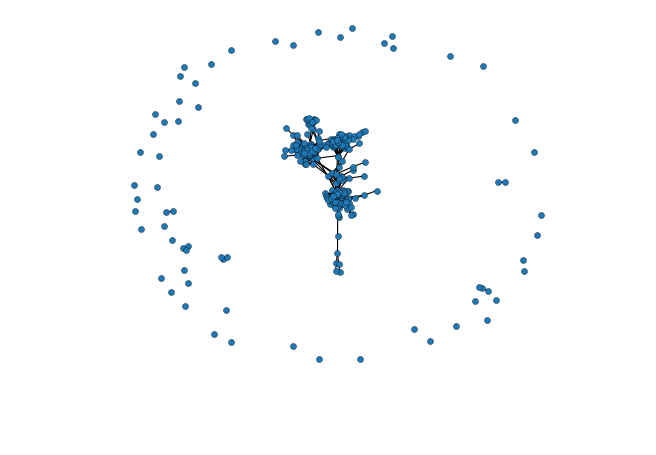

In [506]:
nx.draw(DG, node_size=30)

Filter giant component only

In [507]:
giant_component = max(nx.connected_components(DG), key=len)
GG = DG.subgraph(giant_component)

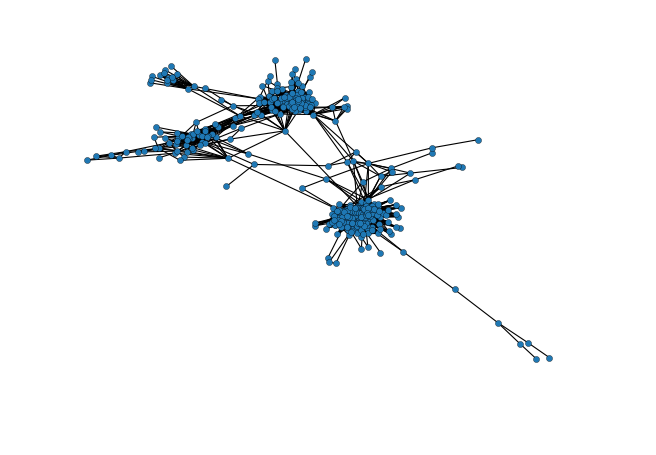

In [508]:
nx.draw(GG, node_size=30)

# Radius and diameter

In [64]:
r = nx.radius(GG)
r

6

In [38]:
d = nx.diameter(GG)
d

11

How about six degrees of separation?

I think it will work when network wil be growing, 678 friends are not quite enough i quess

# Clustering Coefficients

In [969]:
ac = nx.average_clustering(GG)
f'{ac:.02f}'

'0.58'

We see pretty much highly connected network, and this fact follows the law of a social networks

In [78]:
threshold = 2
G_friends_min = GG.subgraph([i for i in GG.nodes if GG.degree[i] > threshold])
len(G_friends_min.nodes)

562

Lets filter some nodes and see clustering value distribution by nodes

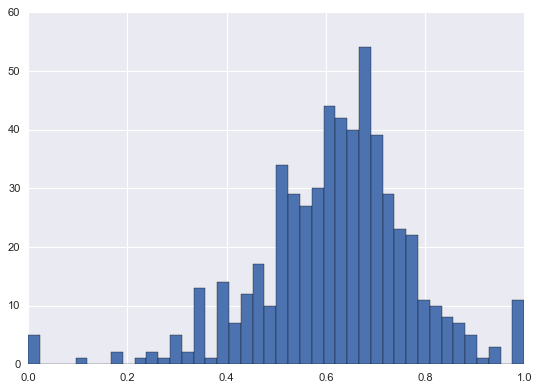

In [161]:
plt.hist(nx.clustering(G_friends_min).values(), bins=42)
None

In [83]:
print(
    f'Global clustering = {nx.transitivity(GG):.2f} (number of closed triplets / all triplets)')


Global clustering = 0.61 (number of closed triplets / all triplets)


# Path lengths

In [1135]:
f'{nx.average_shortest_path_length(GG):.02f}'

'3.19'

In [ ]:
pl = list(nx.all_pairs_shortest_path_length(GG))

In [115]:
lengths = []
for p in pl:
    src, targets = p
    for j in targets.values():
        lengths.append(j)

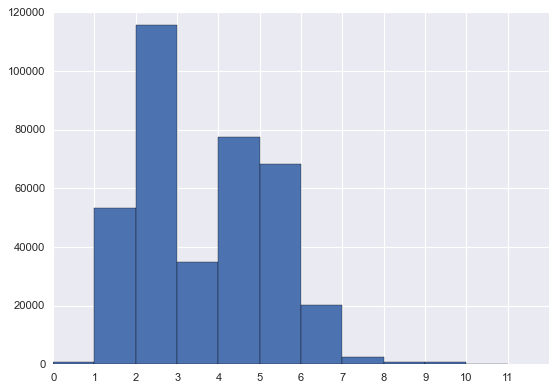

In [139]:
np.histogram(lengths)
n, bins, patches = plt.hist(lengths, bins=np.max(lengths))
plt.xticks(bins)
plt.show()

# Degree distribution

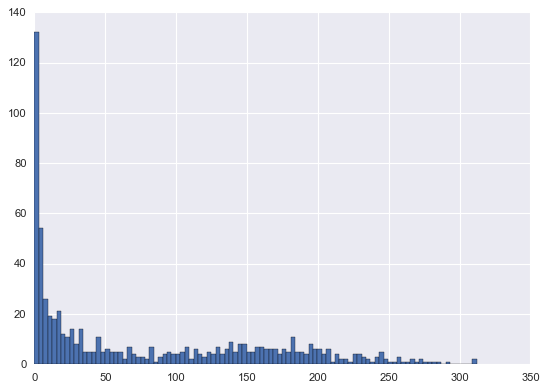

In [157]:
plt.hist(np.array(DG.degree)[:, 1], bins=100)
plt.show()

In [1137]:
from scipy import stats


def power_law_cdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / np.power(float(x_min), (1 - alpha))
    return 1 + (C * np.power(np.array(x).astype(float), (-alpha)) * x / (-alpha + 1))


def mle_power_law_params(degree_sequence, threshold=275):
    r = {}
    ds = degree_sequence.copy()
    idgr = list(map(int, degree_sequence))

    degree_sequence = np.array(degree_sequence)

    for x_min in sorted(set(idgr)):
        degree_sequence = degree_sequence[np.where(degree_sequence > x_min)]
        n = len(degree_sequence)
        if n < threshold:
            continue

        alpha = 1 + n / np.sum(np.log((degree_sequence / x_min)))

        result = stats.kstest(
            degree_sequence,
            power_law_cdf,
            args=(alpha, x_min),
            mode='approx',
            N=n
        )
        r[alpha, x_min] = result

    r = filter(
        lambda item: not (np.isnan(item[1].pvalue) or np.isnan(-item[1].statistic)),
        r.items())
    (alpha, x_min), res = max(r, key=lambda item: (item[1].pvalue, -item[1].statistic))
    print('best', alpha, x_min, res)
    return alpha, x_min


def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / np.power(x_min, (1 - alpha))
    return C * np.power(x, -alpha)

In [1138]:
degree_sequence = np.array(nx.degree_histogram(DG))
alpha, x_min = mle_power_law_params(degree_sequence, threshold=10)
alpha, x_min

best 2.314809134973535 6 KstestResult(statistic=0.1834594642004872, pvalue=0.6067220089692776)


/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_13859/3835978542.py:22: RuntimeWarning: divide by zero encountered in divide
  alpha = 1 + n / np.sum(np.log((degree_sequence / x_min)))
/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_13859/3835978542.py:6: RuntimeWarning: invalid value encountered in divide
  return 1 + (C * np.power(np.array(x).astype(float), (-alpha)) * x / (-alpha + 1))


(2.314809134973535, 6)

best 2.314809134973535 6 KstestResult(statistic=0.1834594642004872, pvalue=0.6067220089692776)


/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_13859/3835978542.py:22: RuntimeWarning: divide by zero encountered in divide
  alpha = 1 + n / np.sum(np.log((degree_sequence / x_min)))
/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_13859/3835978542.py:6: RuntimeWarning: invalid value encountered in divide
  return 1 + (C * np.power(np.array(x).astype(float), (-alpha)) * x / (-alpha + 1))


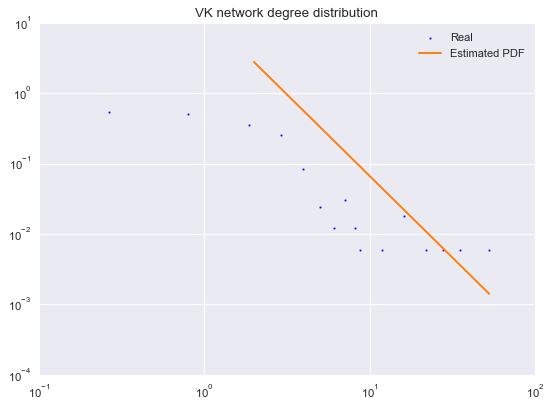

In [1150]:
ax = plt.subplot()
plt.style.use('seaborn-v0_8')
awhist, bin_edges = np.histogram(degree_sequence, bins=100, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
hist, bin_edges = np.histogram(degree_sequence, bins=100, density=True)
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5, label='Real')
ax.set_title('VK network degree distribution')

hat_alpha, hat_x_min = mle_power_law_params(degree_sequence, threshold=10)
x_space = np.linspace(2, degree_sequence.max(), 100)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, hat_x_min),
         label='Estimated PDF', c='tab:orange')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.001, 0.5);

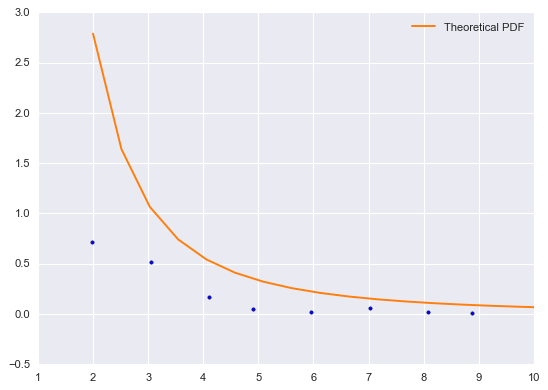

In [224]:
hist, bin_edges = np.histogram(degree_sequence, bins=200, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=10)
plt.plot(x_space, power_law_pdf(x_space, alpha, x_min),
         label='Theoretical PDF', c='tab:orange')
plt.legend()
plt.xlim(1, 10)
plt.show()

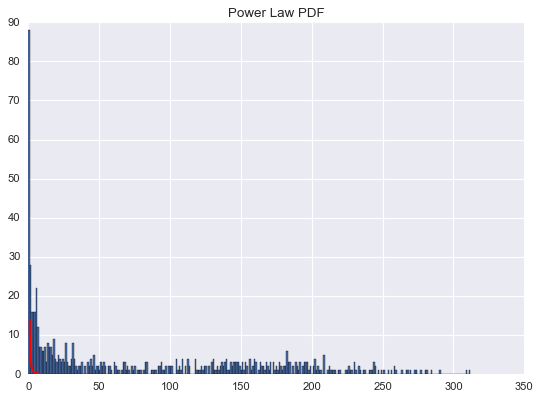

In [248]:
def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / np.power(x_min, (1 - alpha))
    return C * np.power(x, -alpha)


x_space = np.linspace(1, 10, 100)
plt.title('Power Law PDF')
plt.plot(x_space, power_law_pdf(x_space, alpha, x_min), c='r')
plt.hist(np.array(DG.degree)[:, 1], bins=300)
plt.show()

# Gorgeous layout

## By sex

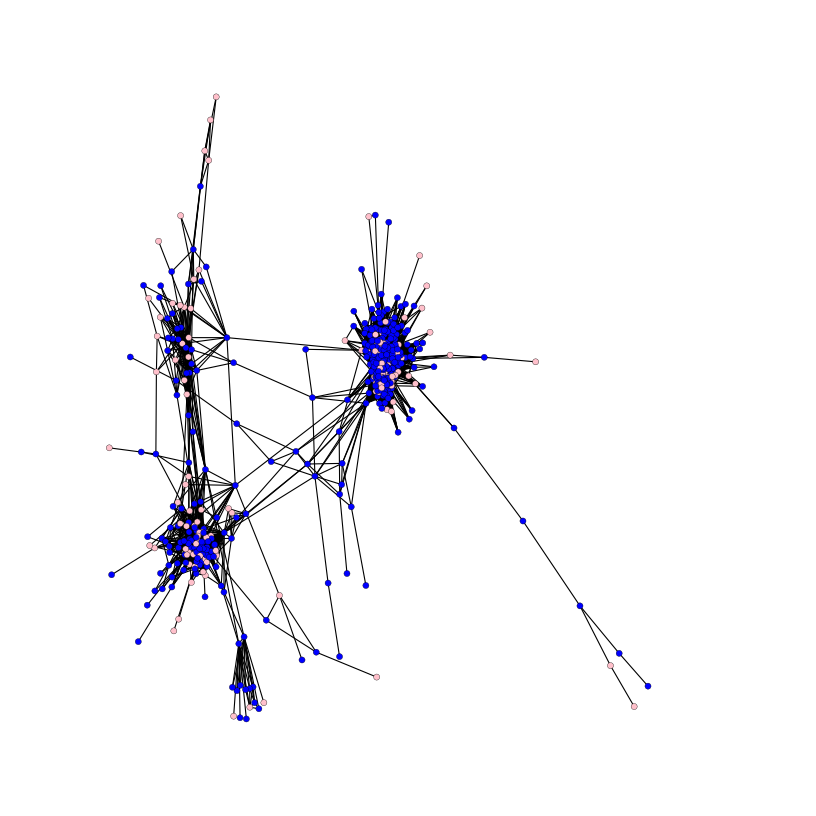

In [269]:
fig = plt.figure(figsize=(10, 10))
color_map = []
for node in GG:
    if G.nodes[node]['sex'] == 1:
        color_map.append('pink')
    else:
        color_map.append('blue')

nx.draw(GG, node_size=30, node_color=color_map,
        # pos=nx.kamada_kawai_layout(GG)
        )

## By common friend count, age, sex

Lets determine the age by birthdate, if no take the mean of friend's

In [325]:
def get_weight(G, node1, node2):
    nbs1 = set(G.neighbors(node1))
    nbs2 = set(G.neighbors(node2))

    return len(nbs1.intersection(nbs2))


def get_widths_by_common_friend(G):
    edges = G.edges()

    weights = []
    for u, v in edges:
        w = get_weight(G, u, v)
        weights.append(w)

    return weights


weights = get_widths_by_common_friend(GG)
weights = np.array(weights)

In [351]:
from datetime import datetime, date


def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))


def get_node_sizes_by_age(G):
    ages = {}
    for node in G:
        bdate = G.nodes[node].get('bdate', 0)
        try:
            born = datetime.strptime(bdate, "%d.%m.%Y")
            age = calculate_age(born)
            ages[node] = age
        except:
            ages[node] = None

    for node in G:
        neighbors = G.neighbors(node)
        neighbors_ages = []
        for neighbor in neighbors:
            neighbor_age = ages[neighbor]
            if neighbor_age is not None:
                neighbors_ages.append(neighbor_age)
        if len(neighbors_ages) == 0:
            continue
        mean_age = np.mean(neighbors_ages)
        ages[node] = mean_age

    result_ages = []
    for node in G:
        age = ages[node]
        if age is None:
            age = 0
        result_ages.append(age)
    result_ages = np.array(result_ages)
    return result_ages


node_sizes = get_node_sizes_by_age(GG)

In [352]:
color_map = []
for node in GG:
    if G.nodes[node]['sex'] == 1:
        color_map.append('pink')
    else:
        color_map.append('blue')

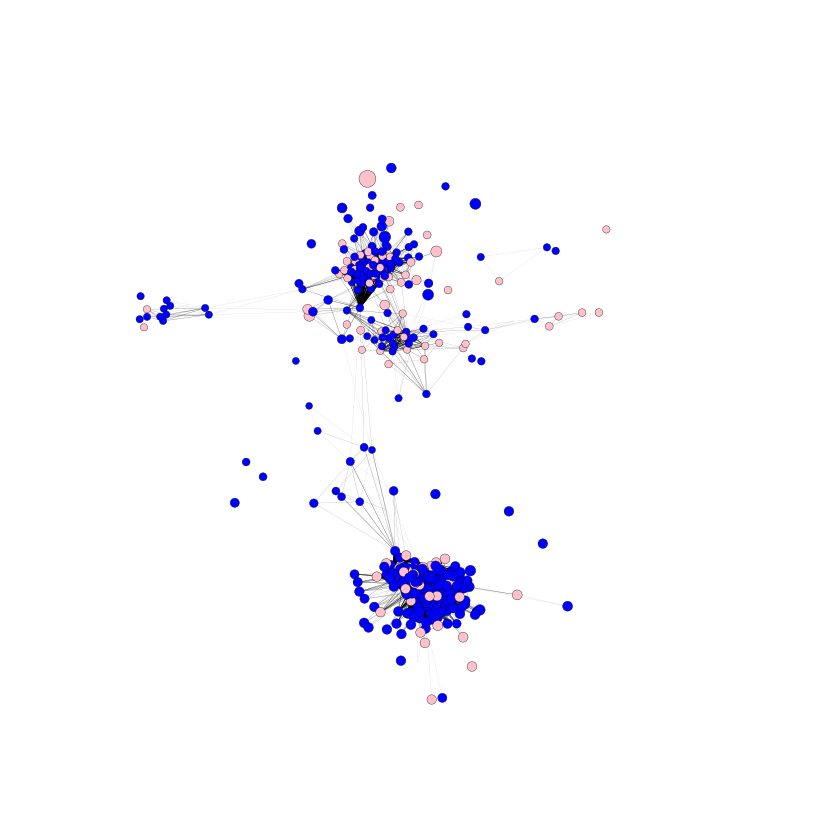

In [363]:

fig = plt.figure(figsize=(10, 10))

nx.draw(GG, node_size=node_sizes * 2, node_color=color_map,
        width=weights / weights.max() * 10,
        )

The mean age is

In [359]:
node_sizes.mean()

33.15512429116173

Saving the graph for other render tools

In [384]:
import csv


def dump_graph(G, path='edges.csv'):
    with open(path, 'w', newline='') as csvfile:
        fieldnames = ['source', 'target', 'weight']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        writer.writerows([{"source": u, "target": v, "weight": w} for (u, v), w in
                          zip(G.edges, weights)])


dump_graph(UG)

In [385]:
!head edges.csv

source,target,weight
25168,25244,137
25168,67341,69
25168,203251,115
25168,220072,98
25168,250674,121
25168,276308,136
25168,307685,164
25168,385125,140
25168,490434,115


# The closest random graph model similar to my social network

In [480]:
def erdos_renyi_graph(n, p):
    G = nx.Graph()
    nodes = np.arange(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(random_edges(nodes, p))
    return G


import itertools


def random_edges(nodes, p):
    mask = np.random.choice(a=[True, False], size=len(nodes) ** 2, p=[p, 1 - p])
    pairs = itertools.combinations(nodes, 2)
    return np.array([(p1, p2) for (p1, p2), m in zip(pairs, mask) if m and p1 != p2])


def estimate_binomial(G):
    n = len(G.nodes)
    p = np.mean(list(dict(nx.degree(G)).values()))
    return n, p / n


def estimate_poisson(G):
    mean = np.mean(list(dict(nx.degree(G)).values()))
    return mean

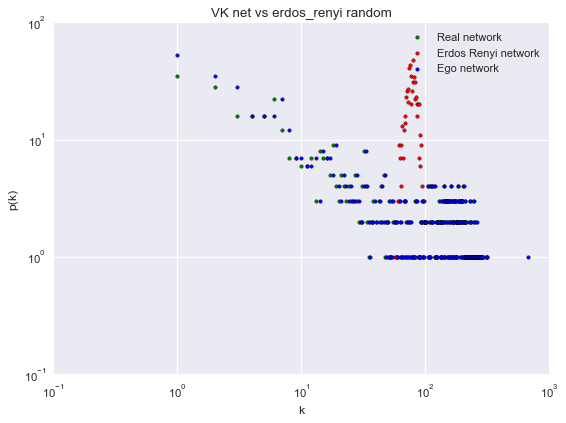

In [490]:
def compare_degree_distributions(Gs, names, title, colors=['g', 'r', 'b']):
    plt.figure()
    for G, name, c in zip(Gs, names, colors):
        degree_hist = np.array(nx.degree_histogram(G))
        idx = np.argwhere(degree_hist > 0)
        plt.scatter(idx, degree_hist[idx], s=10, label=name, c=c)
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.title(title)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()


def random_from_real(graph):
    n, p = estimate_binomial(graph)
    return erdos_renyi_graph(n, p)


real_net = DG
erdos_renyi_net = random_from_real(real_net)

compare_degree_distributions(Gs=[real_net, erdos_renyi_net, UG],
                             names=['Real network', 'Erdos Renyi network',
                                    'Ego network'],
                             title='VK net vs erdos_renyi random')

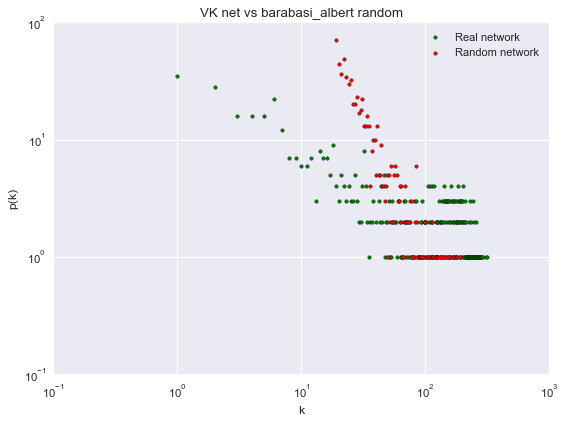

In [491]:
def random_ba_from_real(G):
    n, m = G.number_of_nodes(), G.number_of_edges() // G.number_of_nodes() // 2
    return nx.barabasi_albert_graph(n, m)


real_net = DG
barabasi_albert_net = random_ba_from_real(real_net)

compare_degree_distributions(Gs=[real_net, barabasi_albert_net],
                             names=['Real network', 'Random network'],
                             title='VK net vs barabasi_albert random')

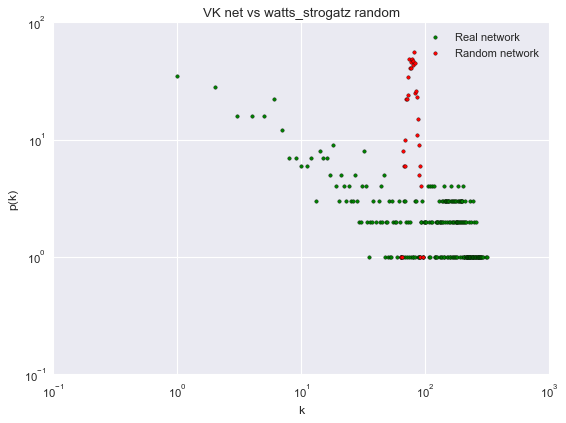

In [492]:
def random_ws_from_real(G):
    n, k = G.number_of_nodes(), int(np.array(G.degree)[:, 1].mean())
    return nx.watts_strogatz_graph(n, k, p=0.5)


real_net = DG
watts_strogatz_net = random_ws_from_real(real_net)

compare_degree_distributions(Gs=[real_net, watts_strogatz_net],
                             names=['Real network', 'Random network'],
                             title='VK net vs watts_strogatz random')

lets check some nets properties

In [511]:
def describe_net(G):
    for k, v in {
        'average path length': nx.average_shortest_path_length(G),
        'diameter': nx.diameter(G),
        'average clustering': nx.average_clustering(G),
    }.items():
        print(f'{k:>40} {v:.2f}')


def describe_nets(Gs):
    for name, G in Gs.items():
        print(f'info for graph {name}')
        describe_net(G)


describe_nets({
    "Friends net": GG,
    "Erdos Renyi net": erdos_renyi_net,
    "Barabasi Albert net": barabasi_albert_net,
    "Watts Strogatz net": watts_strogatz_net,
})

info for graph Friends net
                     average path length 3.19
                                diameter 11.00
                      average clustering 0.58
info for graph Erdos Renyi net
                     average path length 1.89
                                diameter 3.00
                      average clustering 0.11
info for graph Barabasi Albert net
                     average path length 2.09
                                diameter 3.00
                      average clustering 0.12
info for graph Watts Strogatz net
                     average path length 1.89
                                diameter 3.00
                      average clustering 0.17


# Centralities

In [741]:
dtype=[('node', 'int'), ('centrality', 'float'),]
def centrality_to_array(c):
    return np.array(list(c.items()), dtype=dtype)

In [593]:
cc = nx.closeness_centrality(GG)
bc = nx.betweenness_centrality(GG)
dc = nx.degree_centrality(GG)

In [610]:
closeness_centrality = centrality_to_array(cc)
betweenness_centrality = centrality_to_array(bc)
degree_centrality = centrality_to_array(dc)

In [688]:
def render_centralities(G, c, scale=1, bias=0, title='Centrality graph'):
    node_centrality = c['centrality']
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_title(title)
    nx.draw(G,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            cmap=plt.cm.hot,
            node_size=node_centrality * scale + bias,
            node_color=node_centrality,
            )
    plt.show()

def draw_top_centrality(G, centrality, top_k=10, figsize=(15, 15), imgsize = 0.05, layout=nx.spring_layout):
    top_centrality = centrality[centrality['centrality'].argsort()[::-1]][:top_k]
    top_G = G.subgraph(top_centrality['node'])

    pos = layout(top_G)
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(top_G, pos, ax=ax, width=0.1)

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)

    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform

    piesize = imgsize
    p2 = piesize / 2.0
    for n in top_G:
        xx, yy = trans(pos[n])
        xa, ya = trans2((xx, yy))
        a = plt.axes([xa - p2, ya - p2, piesize, piesize])
        a.set_aspect('equal')
        node = top_G.nodes[n]
        url = node['photo_50']
        response = urlopen(url)
        img = Image.open(response)
        img = np.asarray(img, dtype=np.int64)
        a.imshow(img)
        a.set_title(f"{node['first_name']} {node['last_name']}")
        a.axis('off')
    ax.axis('off')
    plt.show()


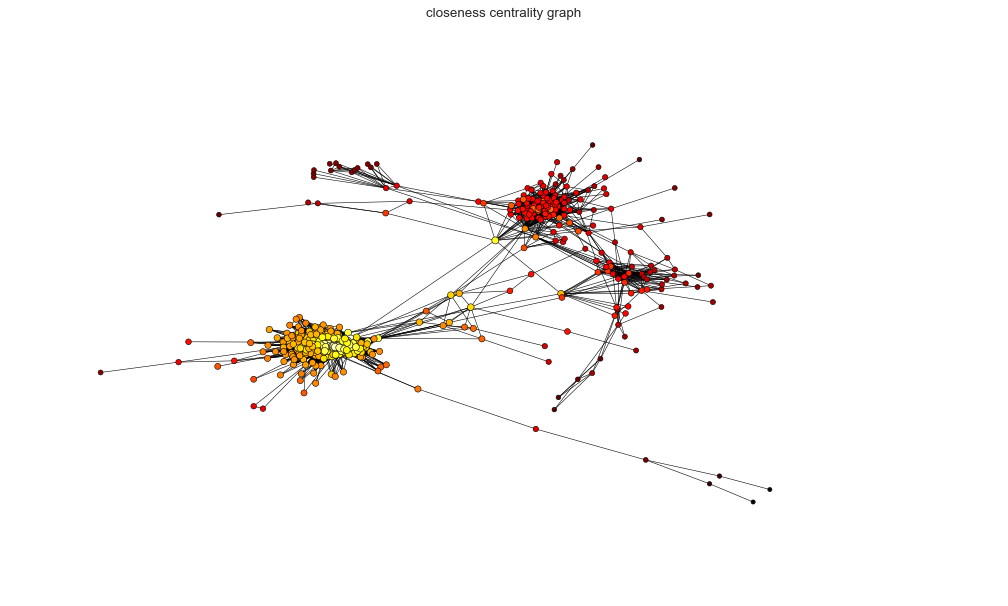

array([(    25168, 0.40814963), (    25244, 0.40625   ),
       (    30817, 0.38917197), (    67341, 0.35094773),
       (   203251, 0.39623865), (   220072, 0.37097753),
       (   241044, 0.3694075 ), (   250674, 0.39393939),
       (   276308, 0.39908556), (   278301, 0.34934248),
       (   307685, 0.41172507), (   341135, 0.37692782),
       (   358387, 0.37392901), (   385125, 0.41423729),
       (   438646, 0.24898126), (   451958, 0.3671875 ),
       (   490434, 0.36004714), (   515201, 0.43862168),
       (   550393, 0.38597599), (   578995, 0.35814771),
       (   654310, 0.39726918), (   666436, 0.44211288),
       (   718317, 0.23970184), (   780960, 0.3852459 ),
       (   791551, 0.21651311), (   807635, 0.42667598),
       (   848668, 0.38942001), (   880518, 0.42342342),
       (   895583, 0.43893678), (   902967, 0.40490391),
       (   939604, 0.37950311), (   956852, 0.34287318),
       (  1025204, 0.42787115), (  1162306, 0.33206522),
       (  1247733, 0.37973897),

In [1058]:
render_centralities(GG, closeness_centrality, scale=100, title='closeness centrality graph')
closeness_centrality

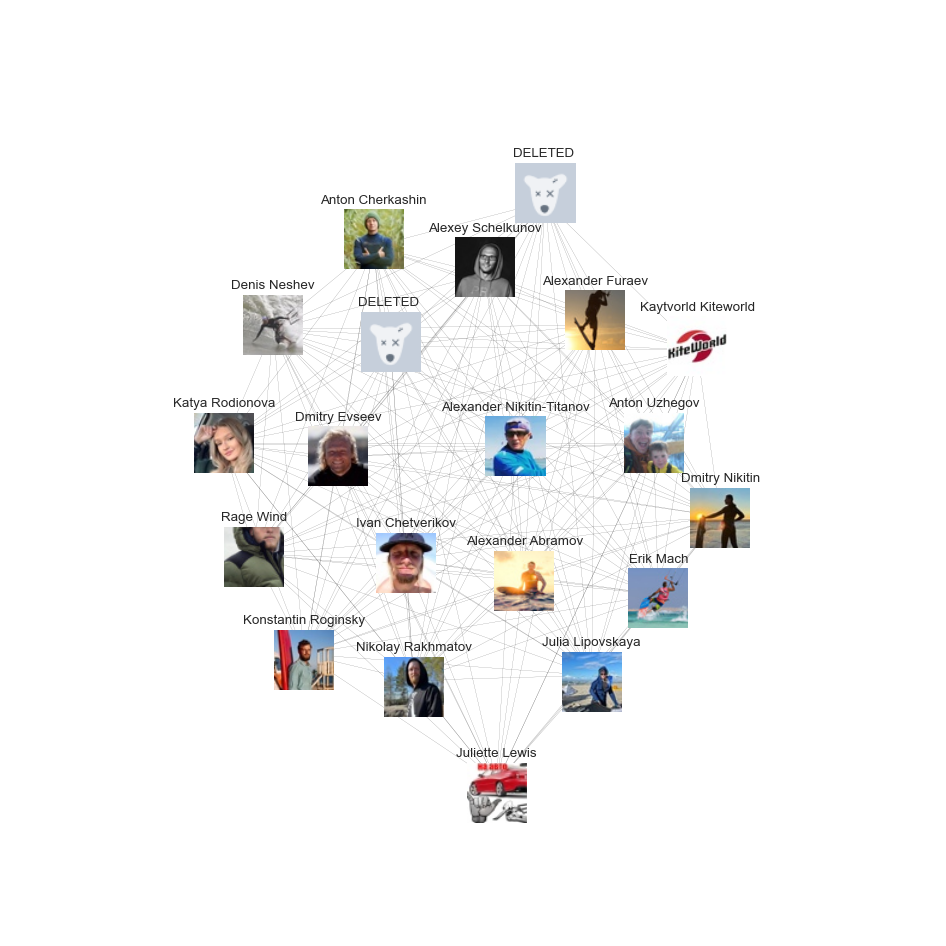

In [697]:
draw_top_centrality(GG, closeness_centrality, top_k=20)

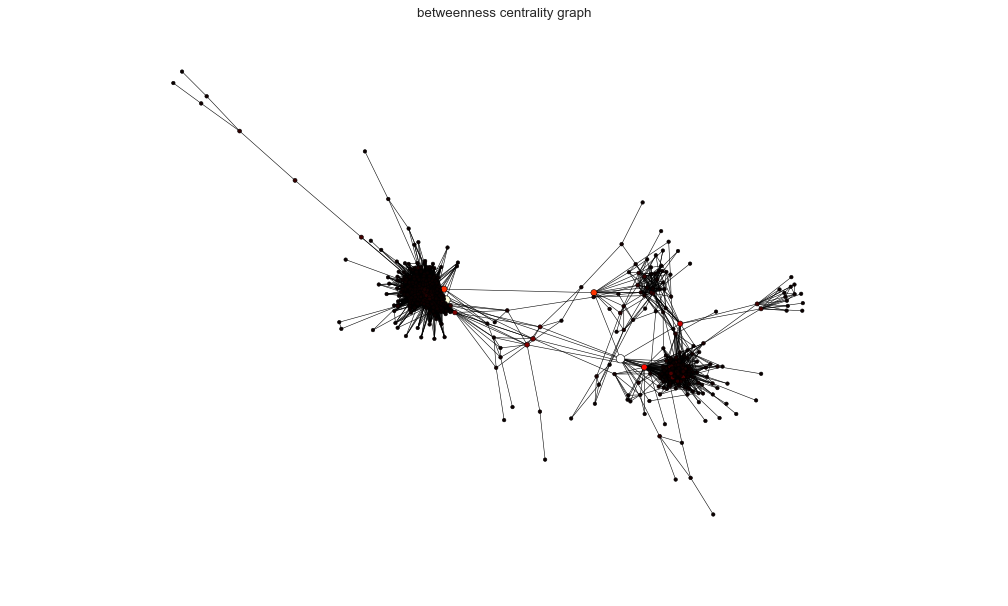

array([(    25168, 1.32057508e-03), (    25244, 2.55232135e-03),
       (    30817, 6.63469710e-04), (    67341, 4.11717745e-04),
       (   203251, 8.59031137e-04), (   220072, 4.95342659e-04),
       (   241044, 5.31734602e-04), (   250674, 4.61212932e-04),
       (   276308, 5.19543547e-04), (   278301, 4.75646845e-04),
       (   307685, 1.58815742e-03), (   341135, 1.21205931e-03),
       (   358387, 1.38474263e-03), (   385125, 4.05119082e-03),
       (   438646, 2.30609231e-04), (   451958, 3.38139586e-04),
       (   490434, 4.67665002e-04), (   515201, 4.69482829e-03),
       (   550393, 1.88590817e-04), (   578995, 6.01913896e-04),
       (   654310, 3.50009252e-03), (   666436, 6.36205769e-03),
       (   718317, 3.21984204e-05), (   780960, 6.28119185e-04),
       (   791551, 3.27677303e-03), (   807635, 3.97642092e-03),
       (   848668, 6.36055429e-04), (   880518, 2.90654541e-03),
       (   895583, 7.89473695e-03), (   902967, 1.90996617e-03),
       (   939604, 9.4962

In [1133]:
render_centralities(GG, betweenness_centrality, scale=200, bias=10,
                    title='betweenness centrality graph')
betweenness_centrality

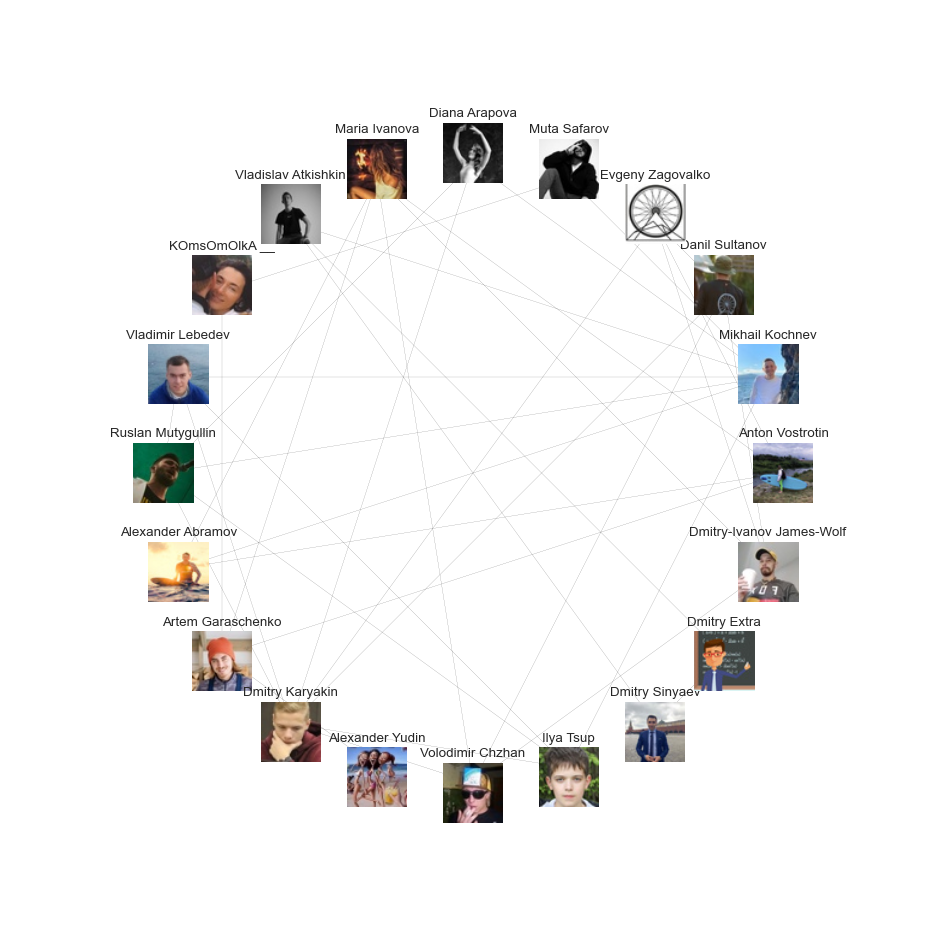

In [1076]:
draw_top_centrality(GG, betweenness_centrality, top_k=20, layout=nx.circular_layout)


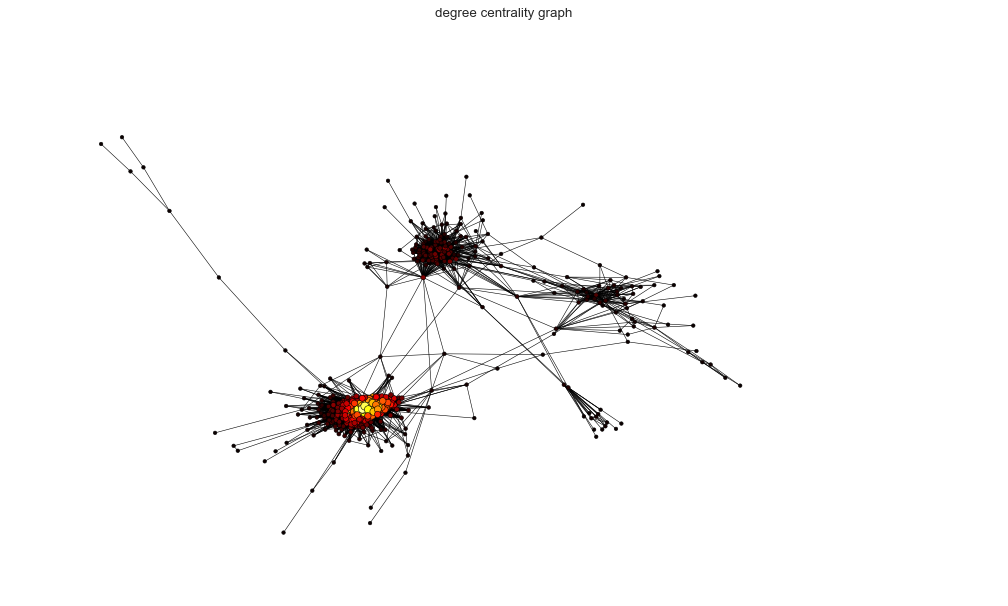

array([(    25168, 0.31914894), (    25244, 0.33060556),
       (    30817, 0.20294599), (    67341, 0.17512275),
       (   203251, 0.25040917), (   220072, 0.21767594),
       (   241044, 0.20294599), (   250674, 0.22913257),
       (   276308, 0.26186579), (   278301, 0.15875614),
       (   307685, 0.34206219), (   341135, 0.12929624),
       (   358387, 0.16366612), (   385125, 0.3502455 ),
       (   438646, 0.02454992), (   451958, 0.19312602),
       (   490434, 0.24549918), (   515201, 0.40425532),
       (   550393, 0.19312602), (   578995, 0.14402619),
       (   654310, 0.36988543), (   666436, 0.41571195),
       (   718317, 0.00327332), (   780960, 0.13584288),
       (   791551, 0.00981997), (   807635, 0.41898527),
       (   848668, 0.2111293 ), (   880518, 0.34042553),
       (   895583, 0.46481178), (   902967, 0.29787234),
       (   939604, 0.2700491 ), (   956852, 0.10801964),
       (  1025204, 0.36006547), (  1162306, 0.03764321),
       (  1247733, 0.17021277),

In [1132]:
render_centralities(GG, degree_centrality, scale=100, bias=10,
                    title='degree centrality graph')
degree_centrality

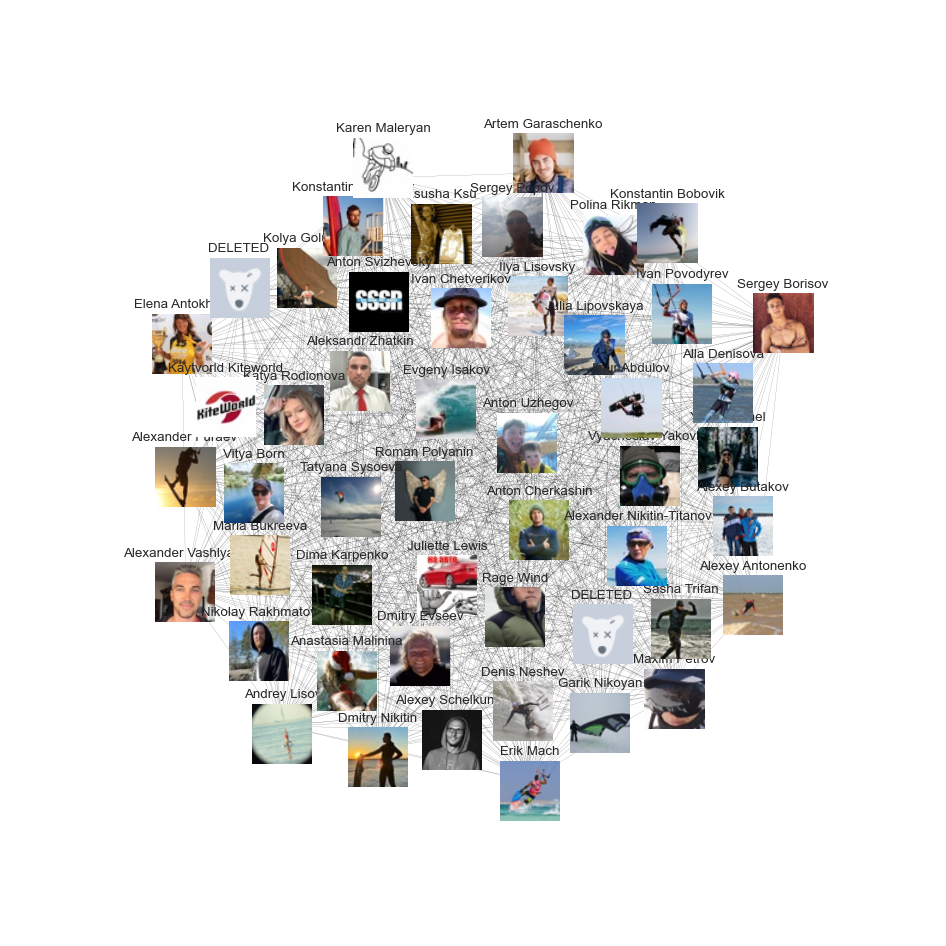

In [695]:
draw_top_centrality(GG, degree_centrality, top_k=50)

# Ranks

## PageRank

In [885]:
def transition_matrix(A):
    sumA = A.sum(axis=1)
    sumA[sumA == 0] = 1
    return A / sumA[:, None]

def teleportation_vector(A):
    return np.ones(A.shape[0]) / A.shape[0]

def update_rank(rank, P, v, alpha):
    return alpha * P.T @ rank + (1 - alpha) * v

def page_rank(G, alpha, k):
    A = nx.to_numpy_array(G)
    P = transition_matrix(A)
    v = teleportation_vector(A)
    rank = np.ones(A.shape[0]) / A.shape[0]
    for _ in range(k):
        rank = update_rank(rank, P, v, alpha)
    return rank / rank.sum()

Display graph with node size based on PageRank value
The red node is the highest PageRank scored

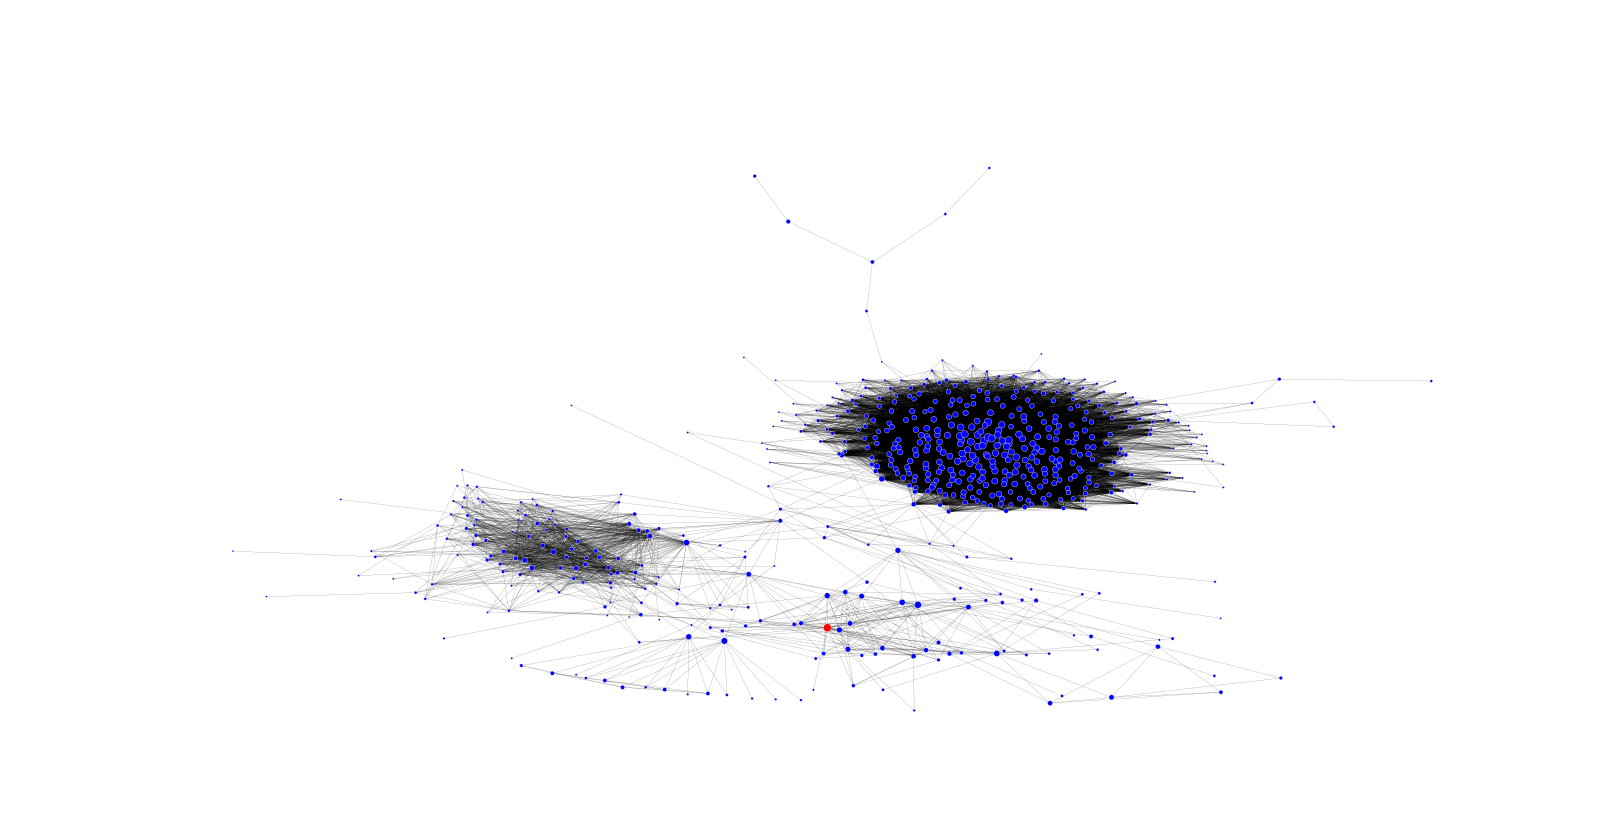

In [912]:
def draw_page_rank(directed_G):
    assert isinstance(directed_G, nx.classes.digraph.DiGraph)
    pr = page_rank(directed_G, 0.9, 100)
    mp = max(pr)
    plt.figure(figsize=(20,10))
    nx.draw_kamada_kawai(
        directed_G.to_undirected(),
        node_size=(pr * 1e4),
        node_color=['red' if rank == mp else 'blue' for rank in pr],
        width=0.1,
    )
    plt.show()
    return pr

def get_giant_directed_ego_free(G):
    GG = G.copy().to_undirected()
    GG.remove_node(MY_USER_ID)
    giant_component = max(nx.connected_components(GG), key=len)
    directed_G = G.subgraph(giant_component).copy()
    return directed_G

GDEFG = get_giant_directed_ego_free(G)
page_ranks = draw_page_rank(GDEFG)

In [1153]:
node_ranks = centrality_to_array({node: r for  node, r in zip(GDEFG.nodes, page_ranks)})
node_ranks

array([(    25168, 0.00281439), (    25244, 0.00297387),
       (    30817, 0.00188761), (    67341, 0.0017386 ),
       (   203251, 0.00233605), (   220072, 0.00202574),
       (   241044, 0.00199431), (   250674, 0.00209487),
       (   276308, 0.00228661), (   278301, 0.00160183),
       (   307685, 0.00295328), (   341135, 0.001461  ),
       (   358387, 0.00170812), (   385125, 0.00329973),
       (   438646, 0.00065158), (   451958, 0.00188907),
       (   490434, 0.00236574), (   515201, 0.00356261),
       (   550393, 0.00176201), (   578995, 0.00159182),
       (   654310, 0.00334344), (   666436, 0.00361555),
       (   718317, 0.00037595), (   780960, 0.00144744),
       (   791551, 0.00073894), (   807635, 0.00374961),
       (   848668, 0.00200194), (   880518, 0.00306177),
       (   895583, 0.00418845), (   902967, 0.00275044),
       (   939604, 0.00255603), (   956852, 0.00125901),
       (  1025204, 0.00325573), (  1162306, 0.00057356),
       (  1247733, 0.00172484),

Lets draw the circular graph and see some relations

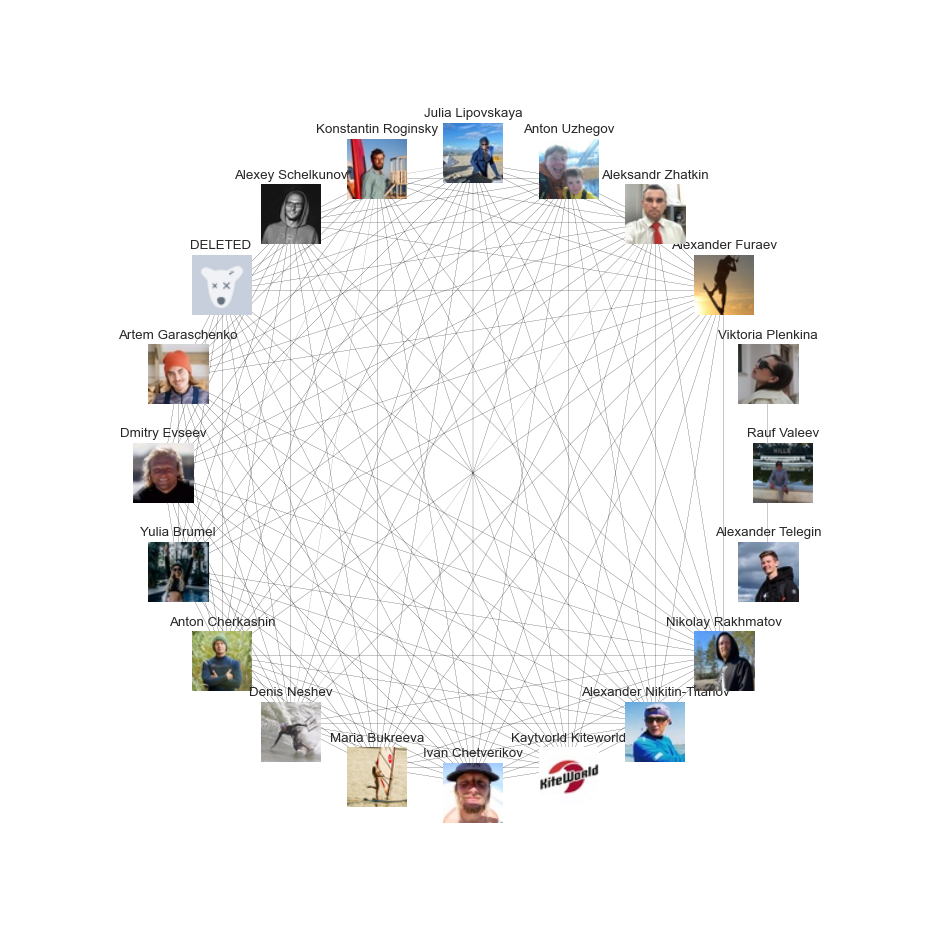

In [827]:
draw_top_centrality(GDEFG, node_ranks, top_k=20, layout=nx.circular_layout)

Check multiple types of similarity values

In [913]:
def sim_values(A, i, j):
    Ai, Aj = A[i], A[j]
    rij = (((Ai - Ai.mean())*(Aj - Aj.mean())).sum() / (len(Ai))) / (np.std(A[i]) * np.std(A[j]))
    Jij = np.array(
      A[i] * A[j]
    ).sum() / np.array(
      (A[i] + A[j])>0
    ).sum()

    cosij = A[i].T @ A[j] / (np.linalg.norm(A[i]) * np.linalg.norm(A[j]))

    return rij, Jij, cosij

In [ ]:
def get_sims(G):
    A = nx.to_numpy_array(G)
    cos_sim = np.zeros(A.shape)
    pearson_sim = np.zeros(A.shape)
    jaccard_sim = np.zeros(A.shape)

    for i in range(len(G)):
        for j in range(i, (len(G))):
            pval, jval, cval = sim_values(A, i, j)
            pearson_sim[i, j] = pval
            pearson_sim[j, i] = pval
            jaccard_sim[i, j] = jval
            jaccard_sim[j, i] = jval
            cos_sim[i, j] = cval
            cos_sim[j, i] = cval
    return cos_sim, pearson_sim, jaccard_sim

cos_sim, pearson_sim, jaccard_sim = get_sims(GDEFG)

In [915]:
cos_sim, pearson_sim, jaccard_sim = map(lambda l: np.nan_to_num(l, 0), (cos_sim, pearson_sim, jaccard_sim))

Render values in matrix form, we see some nodes has strong relations

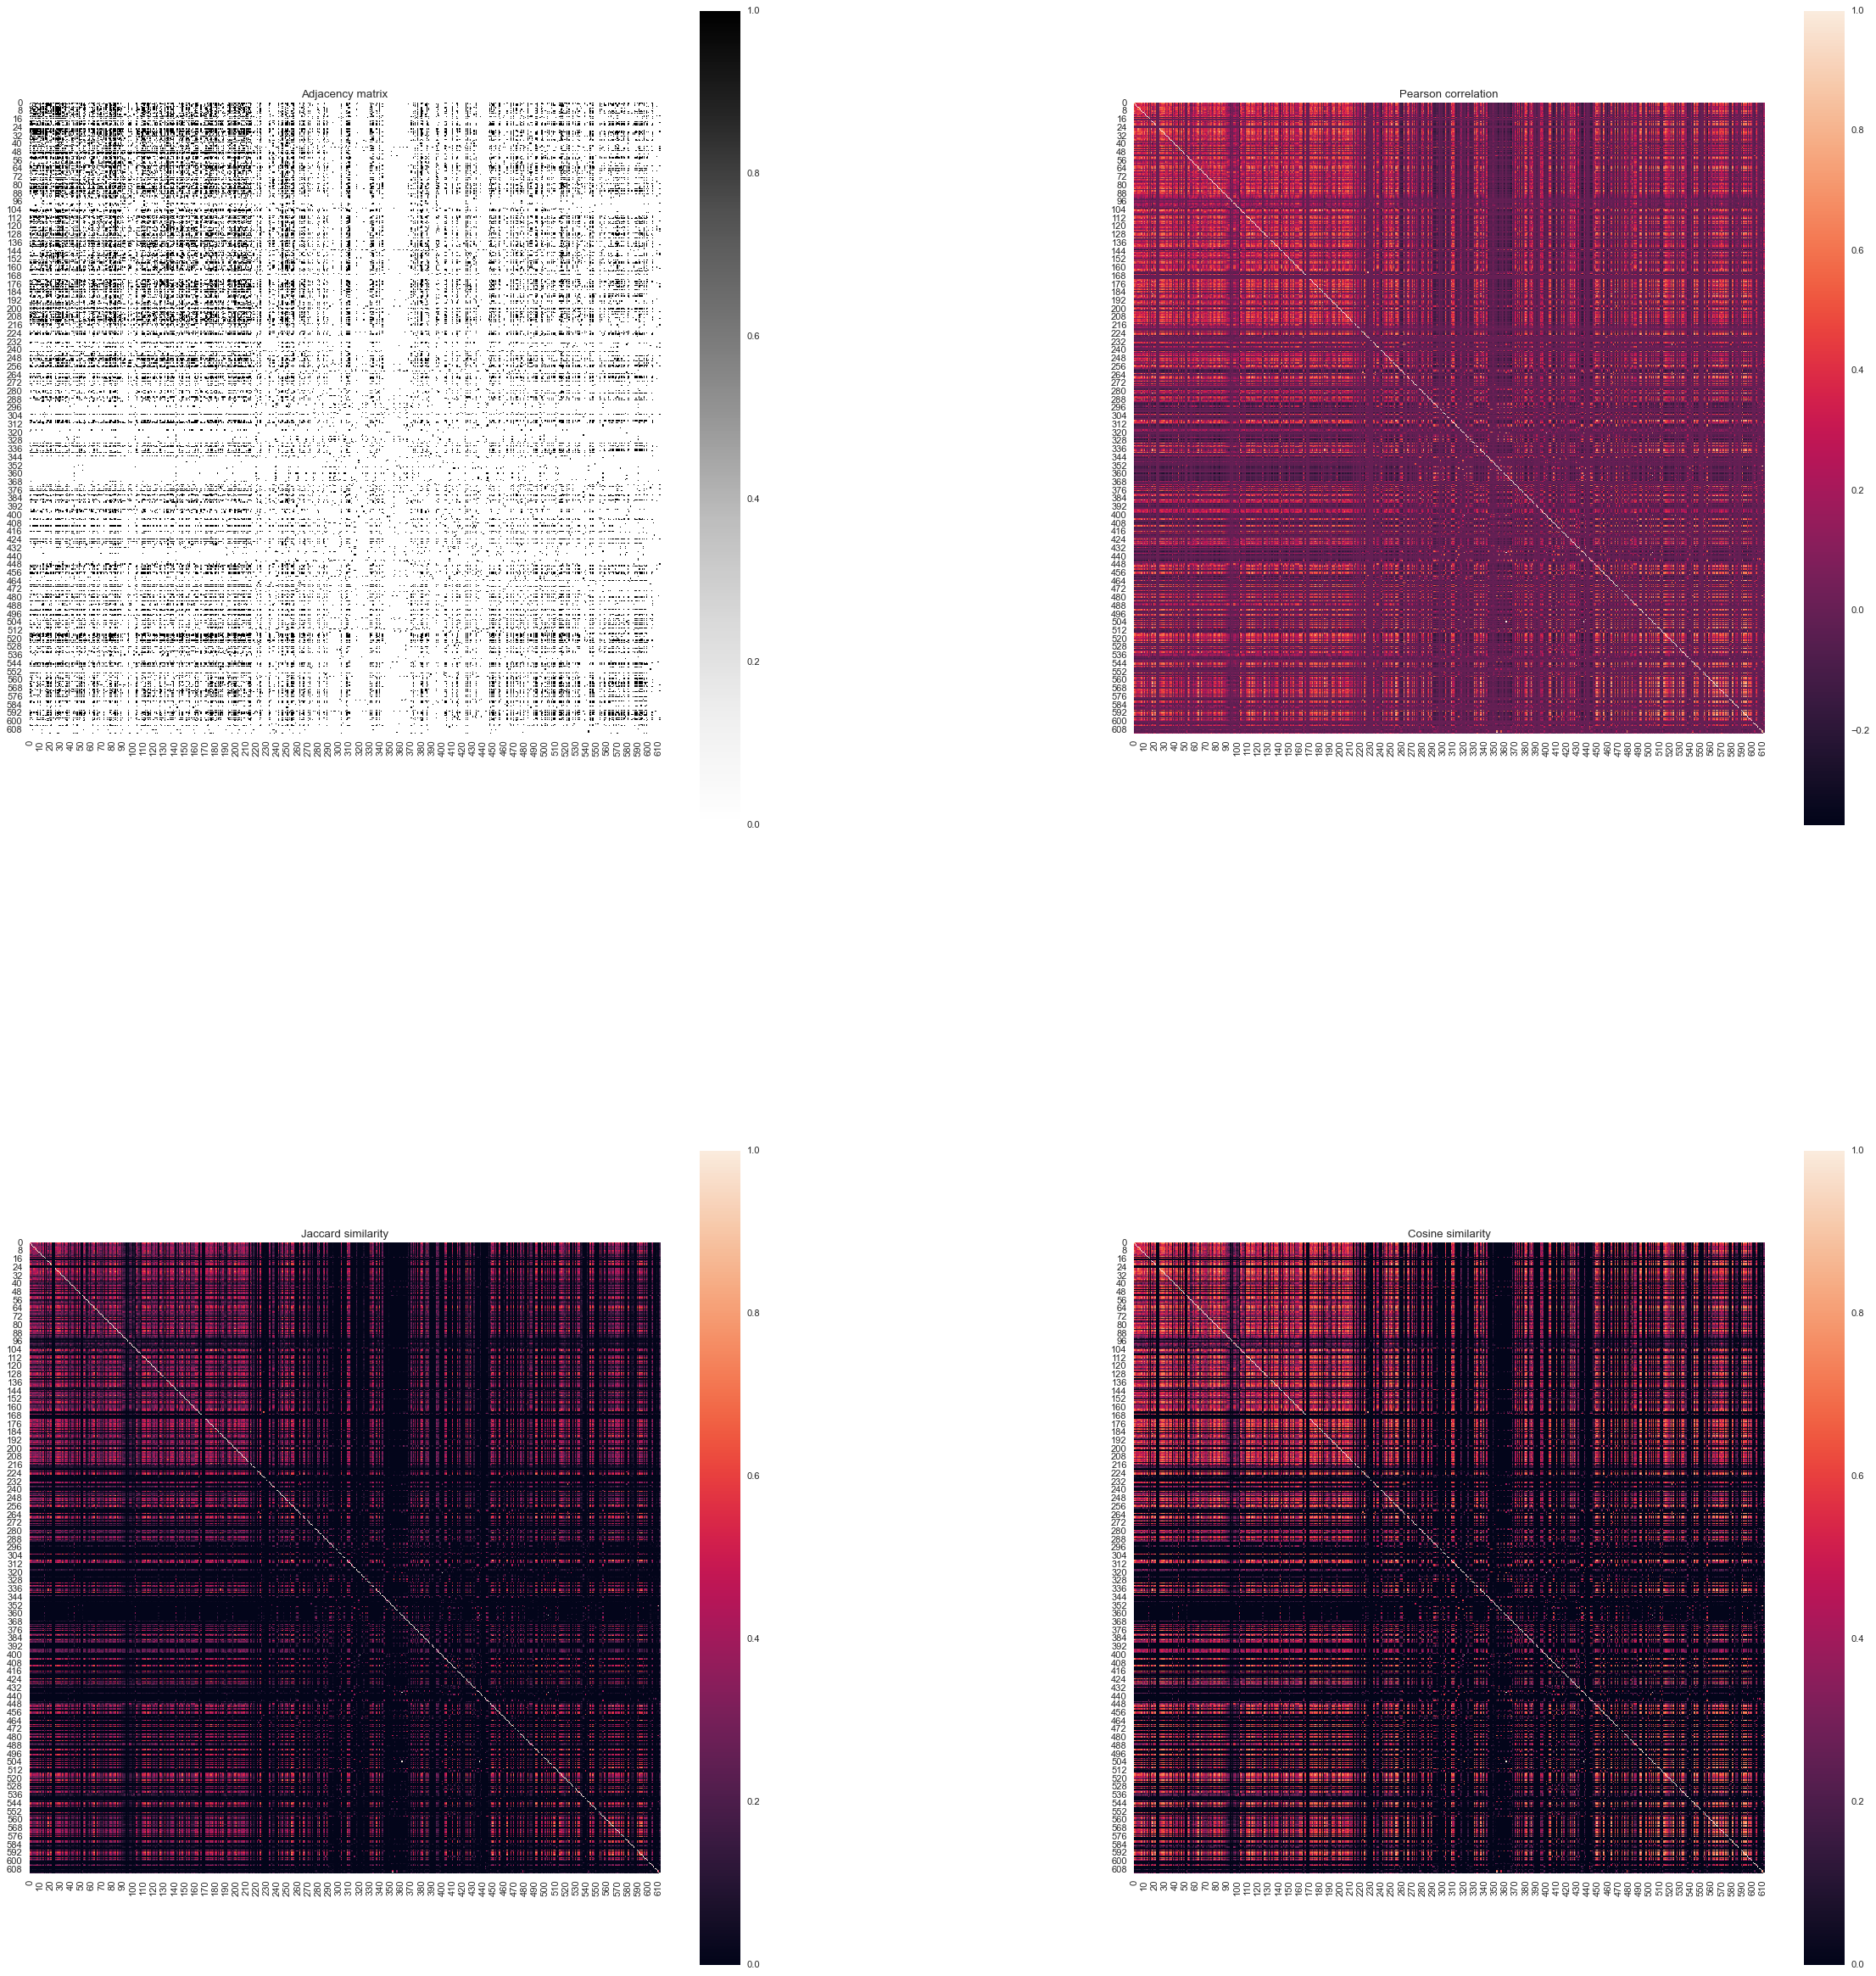

In [916]:
import seaborn as sns

def plot_sims(G):
    fig = plt.figure(figsize=(9*4, 9*4))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    cases = [[1, nx.to_numpy_array(G), plt.cm.Greys, 'Adjacency matrix'],
             [2, pearson_sim, None, 'Pearson correlation'],
             [3, jaccard_sim, None, 'Jaccard similarity'],
             [4, cos_sim, None, 'Cosine similarity'], ]
    for i, matrix, cmap, t in cases:
        ax = plt.subplot(2, 2, i)
        hmap = sns.heatmap(
            matrix,
            cmap=cmap,
            square=True,
        )
        ax.set_title(t)

plot_sims(GDEFG)

In [917]:
def get_max_pair(sim):
    return np.unravel_index(np.argmax(sim-np.eye(sim.shape[0])), sim.shape)

Lets draw top nodes on graph

Top similarity for cos_sim
scored: 1.0
	 141894751 Ulya Sheshukova
	 707074079 Andrey Karyakin
Top similarity for pearson_sim
scored: 1.0
	 127436546 Dmitry Kanashin
	 164050455 Vlad Melnikov
Top similarity for jaccard_sim
scored: 1.0
	 127436546 Dmitry Kanashin
	 164050455 Vlad Melnikov


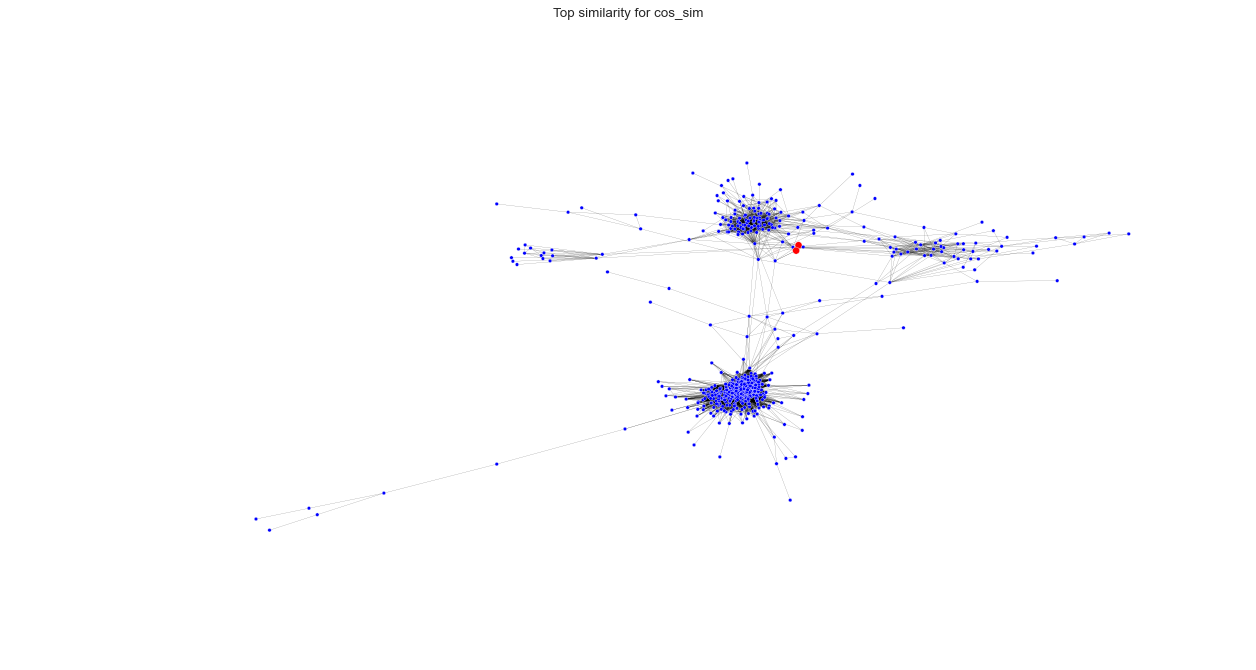

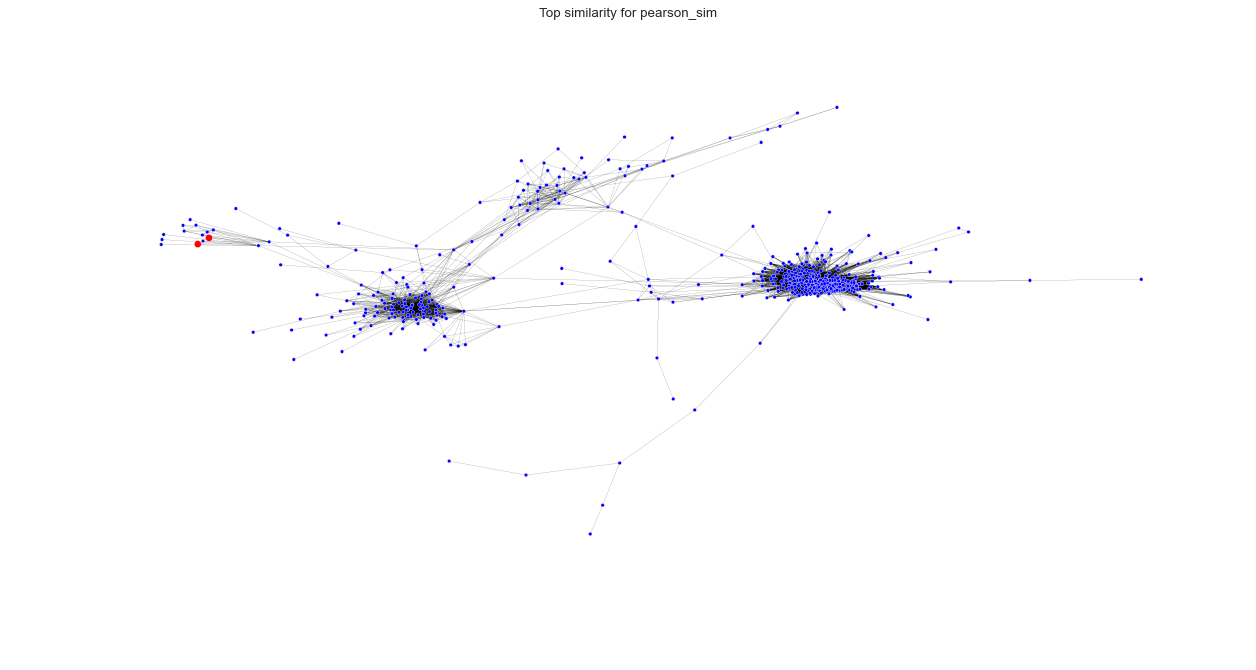

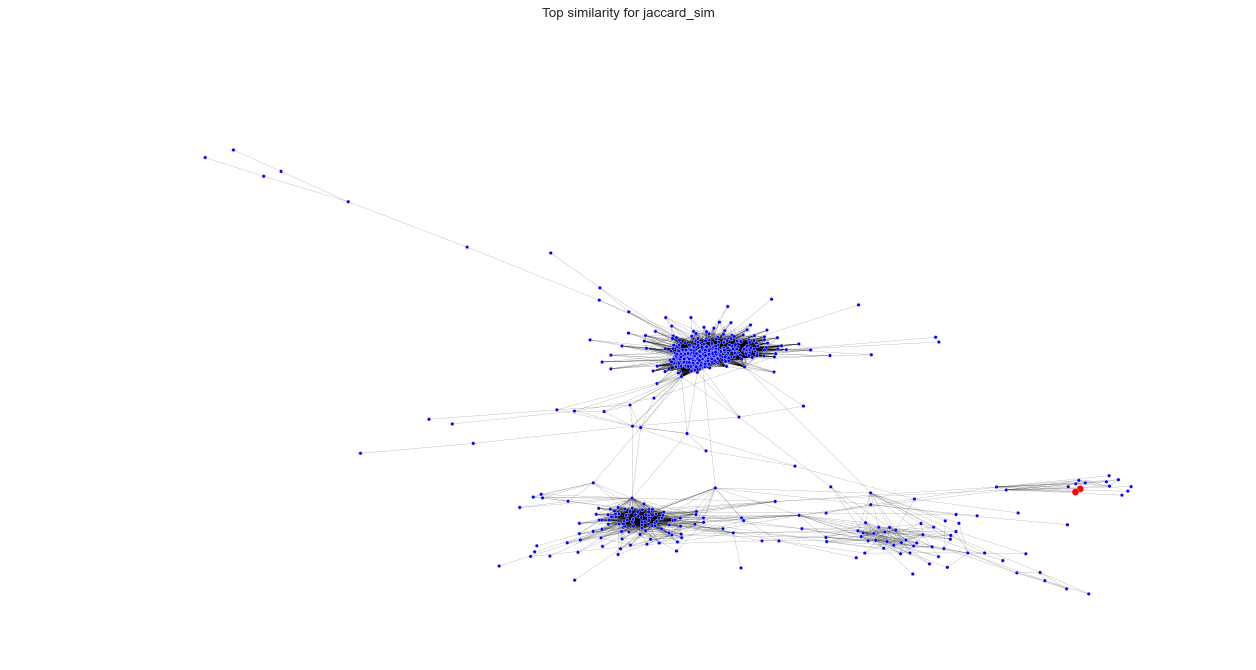

In [920]:
def plot_comparisons(G, sim, title='Top similarity highlight'):
    fig, ax, = plt.subplots(1,1, figsize=(20, 10))
    i, j = get_max_pair(sim)
    node_sizes = [10] * G.number_of_nodes()
    node_colors = ['blue'] * G.number_of_nodes()

    print(title)
    print(f'scored: {sim[i,j]}')
    for x in [i, j]:
        node_id = list(G.nodes)[x]
        node = G.nodes[node_id]
        print('\t', node_id, node['first_name'], node['last_name'])
        node_sizes[x] += 30
        node_colors[x] = 'red'

    nx.draw(
        G,
        node_size=node_sizes,
        node_color=node_colors,
        width=0.1,
    )
    ax.set_title(title)


for name, sim in {'cos_sim': cos_sim, 'pearson_sim': pearson_sim, 'jaccard_sim': jaccard_sim}.items():
    plot_comparisons(GDEFG.to_undirected(), sim, title=f'Top similarity for {name}')

## Assortativitiy

Since I have loaded some node attributes like sex. Lets find an assortative coefficients for the attribute

assortativity_coef (aka pearson corr coef) =  -0.06459520825616168


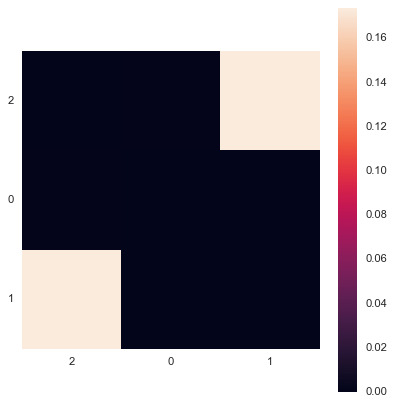

In [954]:
def conferences_mixing_matrix(G, mapping):
    a = []
    lG = list(G.nodes)
    for k1, x in mapping.items():
      row = []
      for k2, y in mapping.items():
        nodes = [lG[i] for i in range(len(G)) if G.nodes[lG[i]]['sex'] in [k1, k2]]
        sG = G.subgraph(nodes)
        connectors = [(a, b) for a, b in sG.edges if sG.nodes[a]['sex'] != sG.nodes[b]['sex']]
        c = len(connectors) / 2 / (len(G.edges))
        row.append(c)
      a.append(row)
    a = np.array(a)
    return a


def assortativity_coef(mixing):
    num = np.diag(mixing).sum() - (mixing @ mixing).sum()
    den = 1 - (mixing @ mixing).sum()
    return num / den


def mix_plot(G):
    conf_values = np.random.permutation(
        np.unique([G.nodes[n]['sex'] for n in G.nodes])
    )
    mapping = {val: i for i, val in enumerate(conf_values)}
    mixing = conferences_mixing_matrix(G, mapping)
    print('assortativity_coef (aka pearson corr coef) = ', assortativity_coef(mixing))

    fig = plt.figure(figsize=(6, 6))
    hmap = sns.heatmap(
        mixing,
        cbar=True,
        square=True)
    hmap.set_xticklabels([m for m in mapping])
    hmap.set_yticklabels([m for m in mapping], rotation=0)
    plt.show()


mix_plot(GDEFG)

## ^ net is a little disassortive

# Community Detection

Lets find the clique

In [956]:
from itertools import product

def largest_cliques(G):
    cs = list(nx.find_cliques(G))
    sorted_cs = list(sorted(cs, key=len))
    max_n = len(sorted_cs[-1])

    largest = list(filter(lambda x: len(x)==max_n, sorted_cs))
    n = len(largest)
    m = len(G.nodes)
    k = len(G.edges)

    rgb = np.ones([n, m, 3])
    for i in range(n):
        for node in largest[i]:
            rgb[i][node] = np.array([0,0,0])


    width = np.zeros([n, k])
    for i in range(n):
        clq = largest[i]
        E = {}
        for ei, (src, tgt) in enumerate(G.edges()):
            E[(src, tgt)] = ei
        for s, t in product(clq, clq):
            if (s,t) not in E:
                continue
            ie = E[(s,t)]
            width[i][ie] = 1

    return rgb, width


Sadly, a bruteforce algorithm for finding a clique takes really long.
But I will leave a code, i case of a smaller network

In [ ]:
colors, widths = largest_cliques(GG)

## K-cores

In [1157]:
def k_core_decompose(G):
    return np.array(list(nx.core_number(G).values()))

labels = k_core_decompose(GG)

In [ ]:
pos = nx.kamada_kawai_layout(GG)
x_max, y_max = np.array(list(pos.values())).max(axis=0)
x_min, y_min = np.array(list(pos.values())).min(axis=0)

We see how graph converges towards the giant cluster when we increase the core size

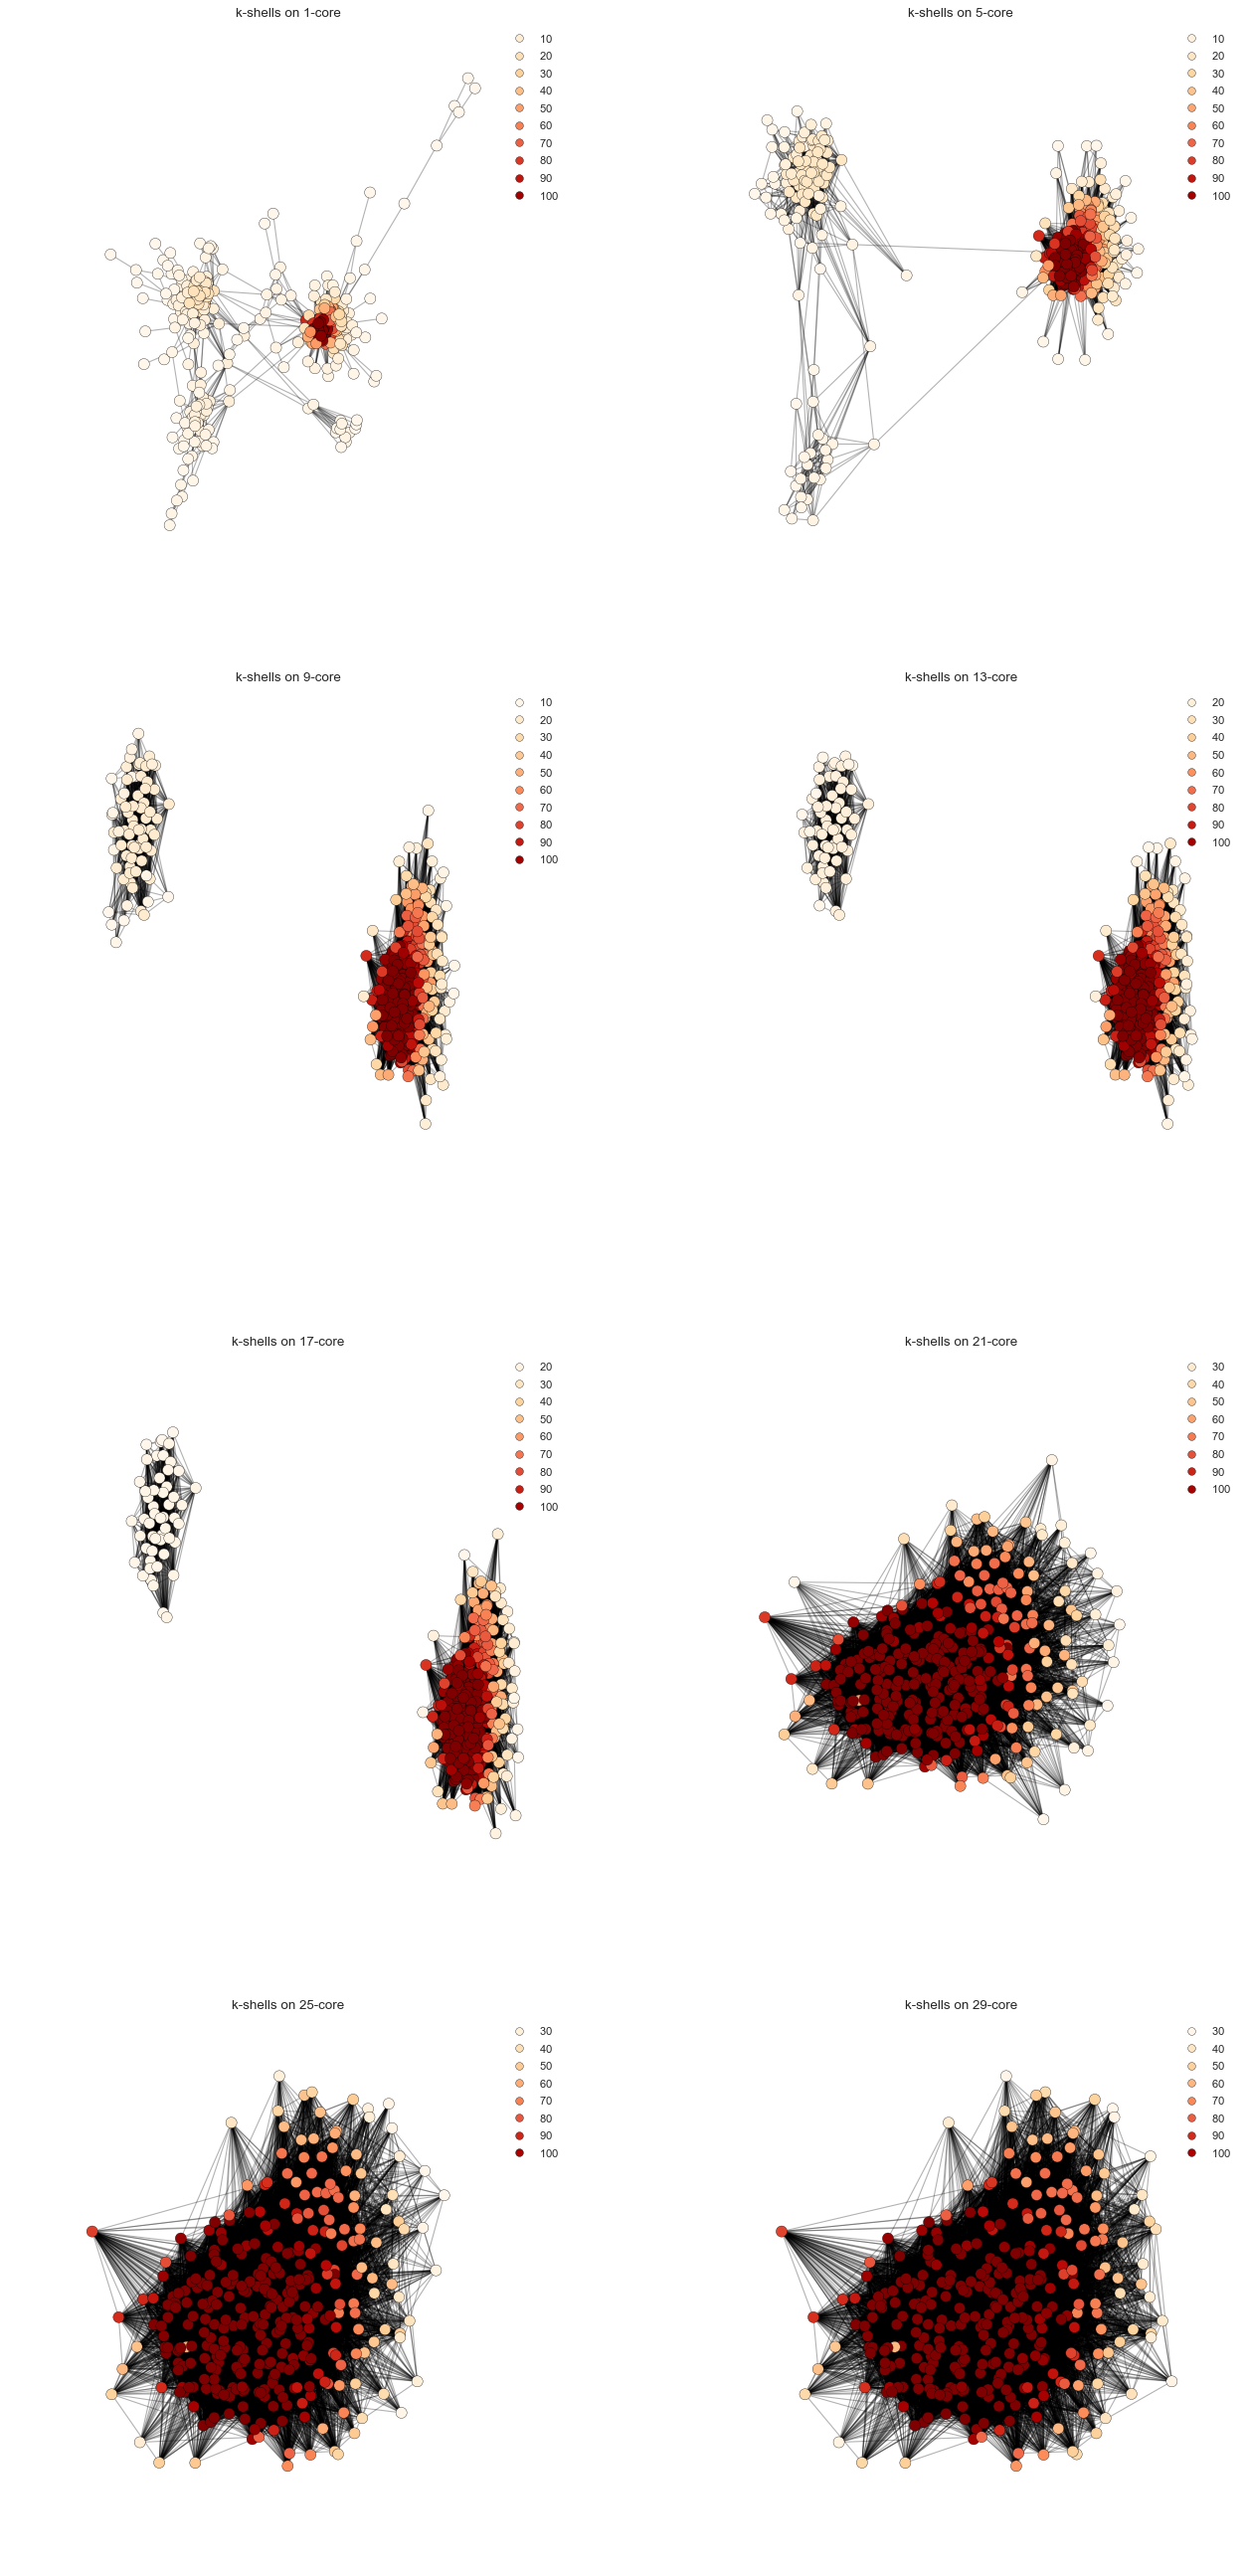

In [1166]:
def plt_shells(pos):
    sz = 10
    plt.figure(figsize=(sz*2, sz*4))
    mult = 4
    for i in range(0, 8, 1):

        ax = plt.subplot(4, 2, i+1)
        subG = nx.k_core(GG, i*mult+1)
        nodes = nx.draw_networkx_nodes(
            subG,
            pos,
            cmap=plt.cm.OrRd,
            node_color=k_core_decompose(subG),
            node_size=100,
            edgecolors='black'
        )
        nx.draw_networkx_edges(
            subG,
            pos,
            alpha=0.3,
            width=1,
            edge_color='black'
        )

        plt.legend(*nodes.legend_elements())
        plt.axis('off')
        ax.set_title('k-shells on {}-core'.format(i*mult+1))
plt_shells(pos)

# Clustering

In [ ]:
def simrank_distance(G):
    d =  nx.simrank_similarity(G)
    A = np.zeros([len(d), len(d)])
    lG = list(G.nodes)
    def get_index(node):
        return lG.index(node)
    for s, v in d.items():
        for t, r in v.items():
            A[get_index(s)][get_index(t)] = 1 - r
            A[get_index(t)][get_index(s)] = 1 - r

    return A

distance = simrank_distance(GG)

Lets build a dendrogram based on simrank distance

we see a single big cluster, and couple smaller ones

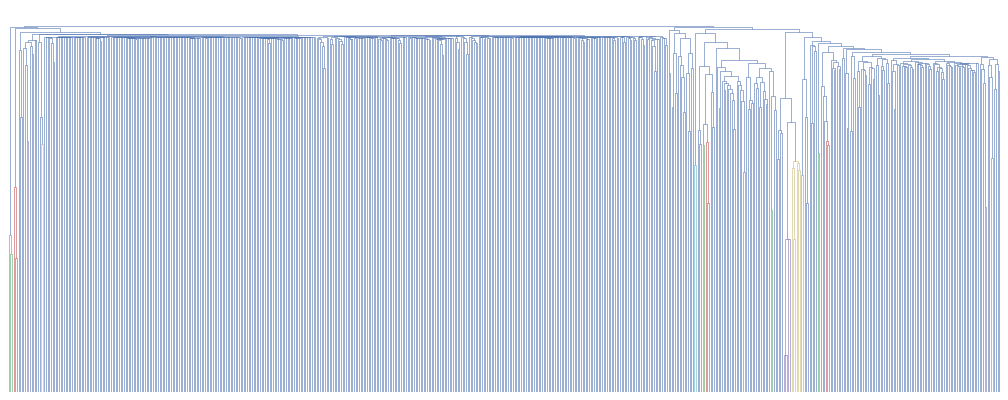

In [992]:
from scipy.cluster._optimal_leaf_ordering import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(16, 6))
linked = linkage(squareform(distance), 'complete')
with plt.rc_context({'lines.linewidth': 0.5}):
    dendrogram(
        linked,
        labels=list(GG.nodes),
        leaf_font_size=3,
    )
    plt.axis('off')

plt.show()

In [994]:
def remove_bridges(G):
    initial = len(list(nx.connected_components(G)))
    while initial >= len(list(nx.connected_components(G))):
        eb = nx.edge_betweenness_centrality(G)
        meb = max(eb.items(), key=lambda x: x[1])
        (s, t), v = meb
        G.remove_edge(s, t)


def girvan_newman(G, n):
    labels = np.zeros((n, len(G)))
    _G = G.copy()
    lG = list(G.nodes)
    def get_index(node):
        return lG.index(node)
    for division in range(n):
        print(division)
        remove_bridges(_G)
        for i, cc in enumerate(nx.connected_components(_G)):
            labels[division, list(map(get_index, list(cc)))] = i
    return labels

labels = girvan_newman(GG, 6)

0
1
2
3
4
5


Lets see the different clusters

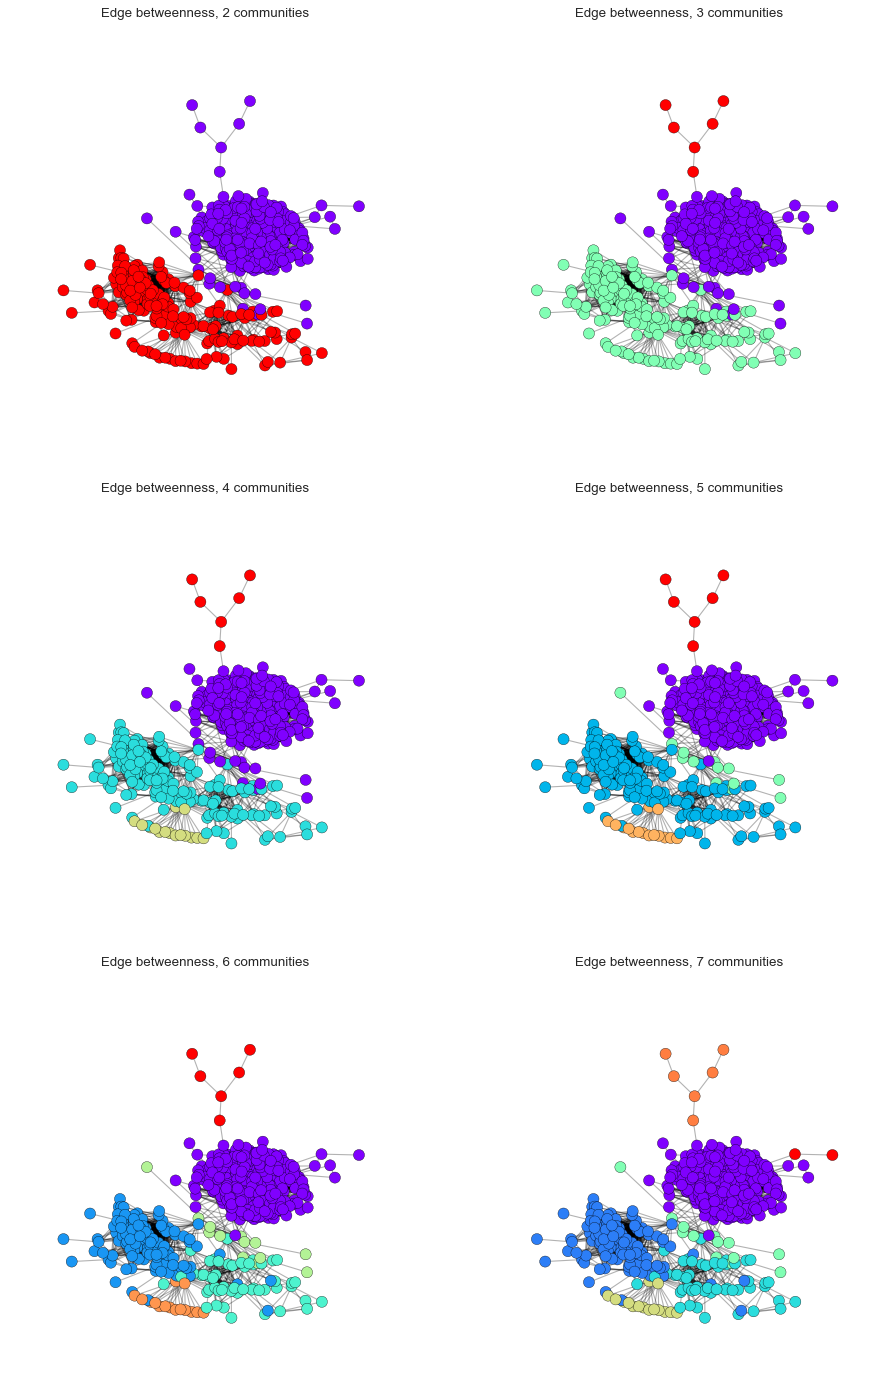

In [996]:
plt.figure(figsize=(7*2, 7*3))
for i in range(labels.shape[0]):
    ax = plt.subplot(3, 2, i+1)
    nx.draw_networkx_nodes(
        GG,
        pos,
        cmap=plt.cm.rainbow,
        node_color=labels[i],
        node_size=100,
        edgecolors='black'
    )
    nx.draw_networkx_edges(GG, pos, alpha=0.3)
    ax.set_title('Edge betweenness, {} communities'.format(i+2))
    plt.axis('off')

## Modularity

In [997]:
def expected_edges(A, m):
    n = A.sum()
    X = A.copy()
    for i in range(A.shape[0]):
        ki = A[i].sum()
        for j in range(A.shape[1]):
            kj = A[j].sum()
            X[i][j]=ki * kj / 2 / m
    return X

def kronecker(A, communities):
    X = np.zeros(A.shape, dtype=int)
    for c, cs in enumerate(communities):
        for i, j in product(cs, cs):
            i, j = map(int, (i, j))
            X[i][j] = 1
    return X


def modularity(A, communities):
    m = A.sum() / 2
    res = (A - expected_edges(A, m)) * kronecker(A, communities)
    return res.sum() / 2 / m

A = nx.to_numpy_array(GG)
m = GG.number_of_edges()
ee = expected_edges(A, m)

In [ ]:
def get_modval():
    r = []
    for label in labels:
        coms = label
        max_c = int(max(coms))
        cs = [list() for _ in range(max_c + 1)]

        for j in range(A.shape[0]):
            cs[int(coms[j])].append(j)
        mod_val = modularity(A, cs)
        r.append(mod_val)
    return np.array(r)

mod_val = get_modval()

Lets check the clusterisation score

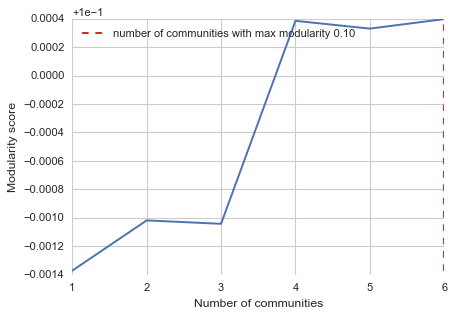

In [1054]:
n_iterations = 6
plt.figure(figsize=(6, 4))

plt.plot(np.arange(len(mod_val))+1, mod_val)
label = 'number of communities with max modularity {:.2f}'.format(max(mod_val))
best_n = np.argmax(mod_val) + 1
plt.plot(
    [best_n, best_n], [min(mod_val), max(mod_val)],
    linestyle='--', c='tab:red',
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.show()

And finally lets render the clusterisation with samples from each cluster

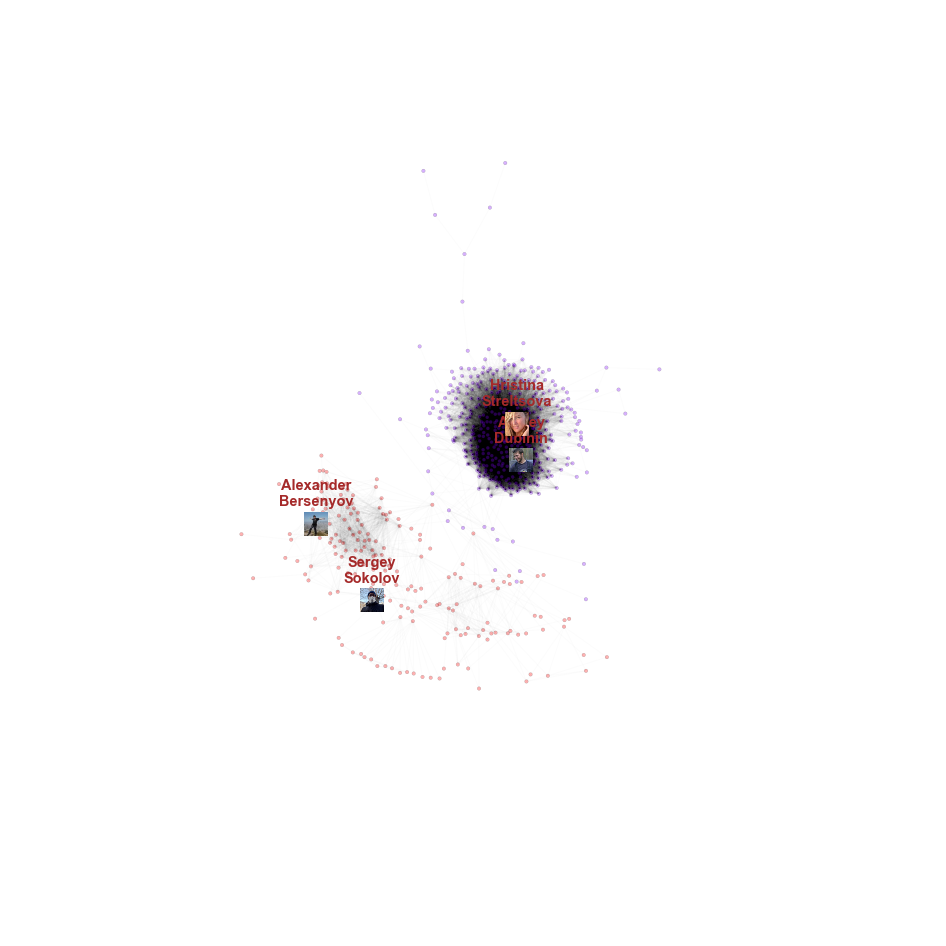

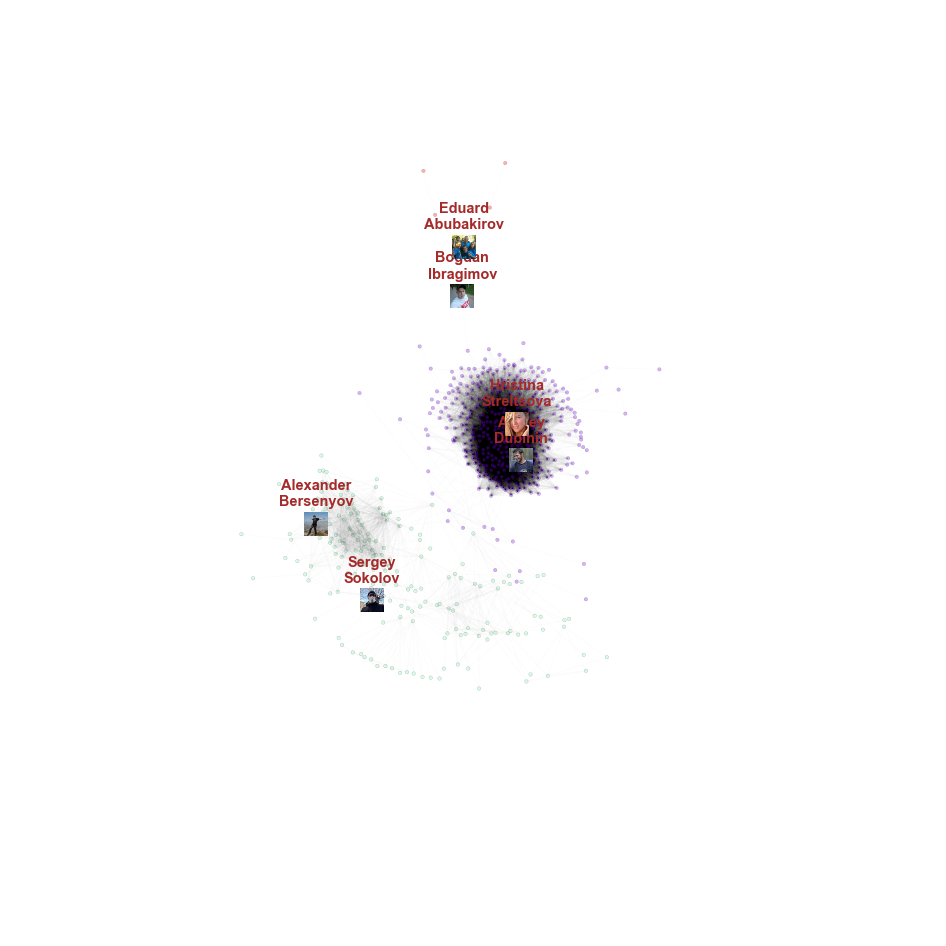

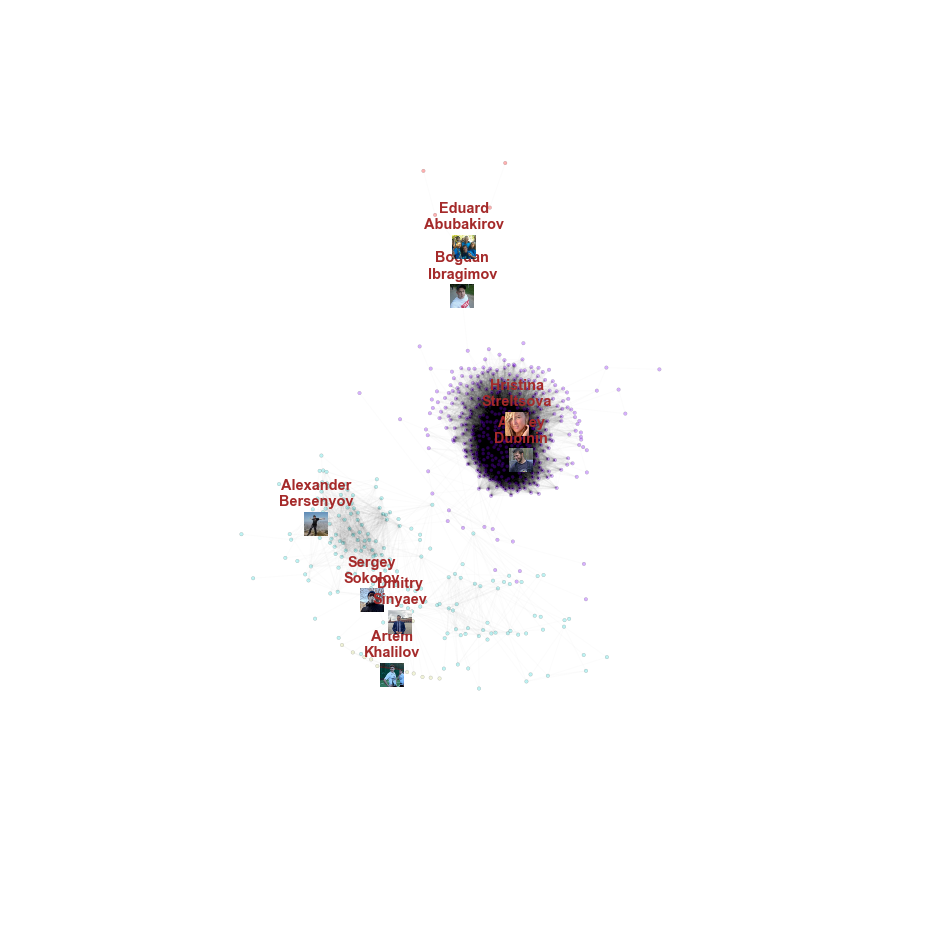

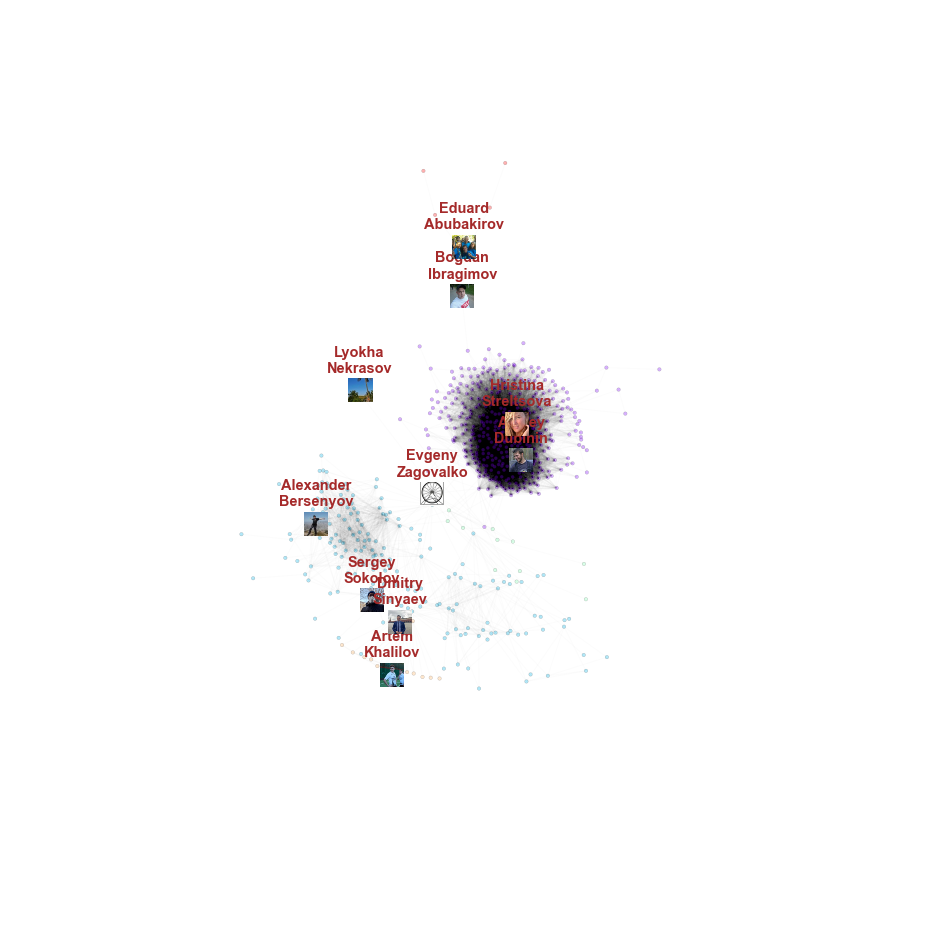

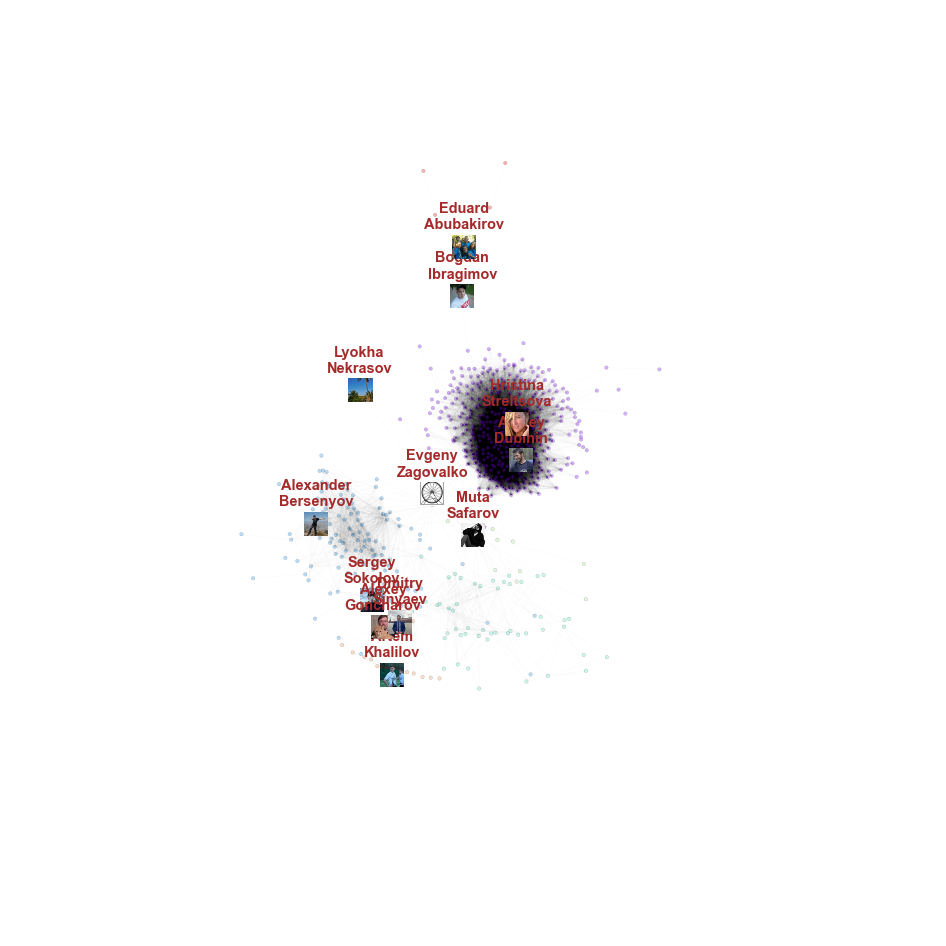

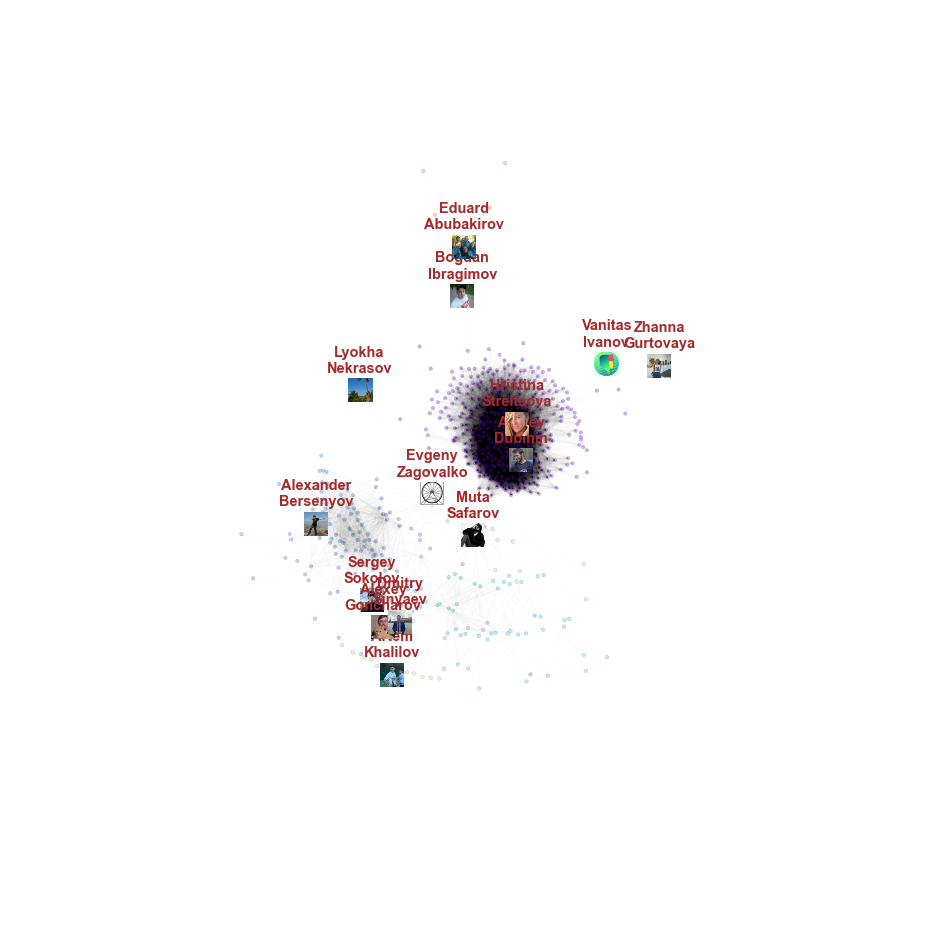

In [1131]:
def draw_samples_from_coms(G, label, pos, samples_from_com=2, figsize=(15, 15), imgsize = 0.02):
    coms = label
    max_c = int(max(coms))
    cs = [list() for _ in range(max_c + 1)]

    for j in range(len(G.nodes)):
        cs[int(coms[j])].append(j)

    lG = list(G.nodes)

    selected_coms = [[lG[numi] for numi in c[:samples_from_com]] for c in cs]
    list_selected_coms = list(itertools.chain(*selected_coms))
    top_G = G.subgraph(list_selected_coms)

    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    ax.set_aspect('equal')

    nx.draw_networkx_nodes(
        G,
        pos,
        cmap=plt.cm.rainbow,
        node_color=label,
        node_size=10,
        edgecolors='black',
        alpha=0.3
    )
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.011)

    # nx.draw_networkx_edges(top_G, pos, ax=ax, width=0.1)

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)

    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform

    piesize = imgsize
    p2 = piesize / 2.0
    for n in top_G:
        xx, yy = trans(pos[n])
        xa, ya = trans2((xx, yy))
        a = plt.axes([xa - p2, ya - p2, piesize, piesize])
        a.set_aspect('equal')
        node = top_G.nodes[n]
        url = node['photo_50']
        response = urlopen(url)
        img = Image.open(response)
        img = np.asarray(img, dtype=np.int64)
        a.imshow(img)
        name, surname = node['first_name'], node['last_name']
        a.set_title(f"{name}\n{surname}", color='brown', fontdict={'fontsize': 13, 'fontweight': 'bold'})

        a.axis('off')
    ax.axis('off')
    plt.show()


for label in labels:
    draw_samples_from_coms(GG, label, pos)

I should mention that this is really accurate clusters, scince every person really comes from different areas of my life
the biggest cluster contains my friend from the time when i was building my athlete carrier
other clusters are the school friends and teachers, and from other activities which I will mention in the presentation

In the end this research has led to a pretty interesting conclusions, I have found out that many of my friends surprisingly have relations which i didnt know about
It was fascinating to see how some friends are similar according to certain metrics.
And it was cool to see the graph structure in 2d plane.